In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%autosave 120

Autosaving every 120 seconds


# ResNet

## Import

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import scipy
from sklearn import metrics
from sklearn import model_selection

import torch
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cudnn.benchmark = True

import albumentations as A

import dataset
import engine
import optimizers
import utils

In [4]:
SEED = 42
utils.seed_everything(SEED)

## Data

In [6]:
DATA_PATH = Path("../input")
df = pd.read_csv(DATA_PATH / "train.csv"); df.head()

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,...,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,...,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2


## Model

In [141]:
def init_cnn(m):
    if getattr(m, "bias", None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d, nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

### ResNet

In [78]:
sigmoid = torch.nn.Sigmoid()

class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))

swish = Swish.apply

class Swish_module(nn.Module):
    def forward(self, x):
        return swish(x)

swish_layer = Swish_module()
def relu_fn(x):
    """ Swish activation function """
    # return x * torch.sigmoid(x)
    return swish_layer(x)

In [8]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class PreActBlock(nn.Module):
    """Pre-activation version of the BasicBlock"""
    expansion = 1
    
    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )
        else:
            self.shortcut = nn.Sequential()
            
    def forward(self, x):
        x = F.relu(self.bn1(x))
        shortcut = self.shortcut(x)
        x = self.conv1(x)
        out = self.conv2(F.relu(self.bn2(x)))
        out += shortcut
        return out

class Bottleneck(nn.Module):
    """Pre-activation version of the original Bottleneck module."""
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [32]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        
        self.conv1 = conv3x3(1, 64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(1024*block.expansion, num_classes)
        init_cnn(self)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # TODO: simplify flattening
        avg_feats = F.adaptive_avg_pool2d(x, output_size=1)
        max_feats = F.adaptive_max_pool2d(x, output_size=1)
        
#         avg_feats = avg_feats.view(avg_feats.size(0), -1)
#         max_feats = max_feats.view(max_feats.size(0), -1)
        
        x = torch.cat([avg_feats, max_feats], dim=1)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x
    
def ResNet18 (): return ResNet(PreActBlock, [2,2,2,2])
def ResNet34 (): return ResNet(BasicBlock,  [3,4,6,3])
def ResNet50 (): return ResNet(Bottleneck,  [3,4,6,3])
def ResNet101(): return ResNet(Bottleneck,  [3,4,23,3])
def ResNet152(): return ResNet(Bottleneck,  [3,8,36,3])

### xResNet

In [79]:
def conv(ni, nf, kernel_size=3, stride=1, bias=False):
    """Creats a convolutional layer for `XResNet`"""
    return nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, bias=bias)

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    """Creates a convolutional block for `XResNet`."""
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn,]
#     if act: layers.append(nn.ReLU(inplace=True))
    if act: layers.append(Swish_module)  # SWISH
    return nn.Sequential(*layers)

In [146]:
class XResBlock(nn.Module):
    """Creates the standard `XResNet` block."""
    def __init__(self, expansion, ni, nh, stride=1):
        super(XResBlock, self).__init__()
        ni, nf = ni*expansion, nh*expansion
        
        # Convolutional path
        layers = [conv_layer(ni, nh, 1)]
        layers += [conv_layer(nh, nf, 3, stride=stride, zero_bn=True, act=False)] if expansion == 1 else [
                conv_layer(nh, nh, 3, stride=stride),
                conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        self.convs = nn.Sequential(*layers)
        
        # Identity path
        self.idconv = nn.Identity() if ni==nf else conv_layer(ni, nf, 1)
        self.pool = nn.Identity() if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
            
    def forward(self, x): 
        return relu_fn(self.convs(x) + self.pool(self.idconv(x)))

In [147]:
class XResNet(nn.Sequential):
    def __init__(self, expansion, layers, num_classes=10):
        stem = [conv_layer(1, 64), nn.BatchNorm2d(64)]
        
        # `XResNet` blocks
        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], blocks=l, stride=1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        
        # Putting it all together
        super().__init__(
            *stem, 
            *blocks,
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(block_szs[-1]*expansion, num_classes),
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(*[
            XResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
            for i in range(blocks)
        ])

def XResNet18 (**kwargs): return XResNet(1, [2, 2,  2, 2], **kwargs)
def XResNet34 (**kwargs): return XResNet(1, [3, 4,  6, 3], **kwargs)
def XResNet50 (**kwargs): return XResNet(4, [3, 4,  6, 3], **kwargs)
def XResNet101(**kwargs): return XResNet(4, [3, 4, 23, 3], **kwargs)
def XResNet152(**kwargs): return XResNet(4, [3, 8, 36, 3], **kwargs)

## Train

In [148]:
def run(model_name, optim_name, epochs, lr, wd, augs=None, label_smooth=True, mixup=False, cutmix=False):
    device = torch.device("cuda" if torch.cuda.is_available else "cpu")
    oof = np.zeros((len(df), 10))
    targs = np.zeros(len(df))
    
    for fold in range(5):
        train_indices = np.load(DATA_PATH / f"train_idx-fold{fold}.npy")
        valid_indices = np.load(DATA_PATH / f"valid_idx-fold{fold}.npy")
        train_dataset = dataset.EMNISTDataset(df, train_indices, augs=augs)
        valid_dataset = dataset.EMNISTDataset(df, valid_indices)
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True
        )
        valid_loader = torch.utils.data.DataLoader(
            valid_dataset, batch_size=256, num_workers=2, pin_memory=True
        )

        # GET MODEL
        if model_name == "resnet18":
            model = ResNet18()
        elif model_name == "resnet34":
            model = ResNet34()
        elif model_name == "resnet50":
            model = ResNet50()
        elif model_name == "xresnet18":
            model = XResNet18()
        elif model_name == "xresnet34":
            model = XResNet34()
        elif model_name == "xresnet50":
            model = XResNet50()
        else:
            raise RuntimeError("Unknown model name:", model_name)
        model.to(device)
        
        # GET OPTIMIZER THAT DOESN'T DECAY BATCHNORM
        skip_list = ["bias", "bn"]
        params = []
        exclude_params = []
        for name, param in model.named_parameters():
            if not param.requires_grad: continue
            elif any(skip in name for skip in skip_list):
                exclude_params.append(param)
            else:
                params.append(param)
        optim_params = [
            {"params": params, "weight_decay": wd},
            {"params": exclude_params, "weight_decay": 0.0},
        ]
        
        if optim_name == "radam":
            optimizer = optimizers.RAdam(optim_params, lr=lr)
        elif optim_name == "adam":
            optimizer = torch.optim.Adam(optim_params, lr=lr)
        else:
            raise RuntimeError("Unknown optimizer:", optim_name)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        scaler = torch.cuda.amp.GradScaler()
    
        train_accuracies = []
        valid_accuracies = []
    
        for epoch in range(epochs):
            # Train
            train_loss, train_accuracy = engine.train(
                train_loader,
                model,
                optimizer,
                device,
                scaler,
                label_smooth=label_smooth,
                mixup=mixup,
                cutmix=cutmix,
            )
            scheduler.step()
            train_accuracies.append(train_accuracy)

            # Validate
            valid_probs, valid_targs, valid_loss, valid_accuracy = engine.evaluate(valid_loader, model, device)          
            valid_accuracies.append(valid_accuracy)
            if epoch % 10 == 0:
                print(f"Epoch={epoch}, Train loss={train_loss:.5f}, Valid loss={valid_loss:.5f}, Train Accuracy={train_accuracy:.5f}, Validation Accuracy={valid_accuracy:.5f}")

        valid_probs, valid_targs, valid_loss, valid_accuracy = engine.evaluate(valid_loader, model, device)
        print(f"Fold={fold}, Valid loss={valid_loss:.5f}, Valid Accuracy={valid_accuracy:.5f}")
        
        # oof prediction
        oof[valid_indices] = scipy.special.softmax(valid_probs, axis=1)
        targs[valid_indices] = valid_targs

        # Plot training curve
        rng = np.arange(len(train_accuracies))
        plt.plot(rng, train_accuracies, label="Train")
        plt.plot(rng, valid_accuracies, label="Validation")
        plt.title(f"Training curve for fold{fold}")
        plt.ylabel("Accuracy")
        plt.xlabel("Epoch")
        plt.legend()
        plt.show()

    # Confusion matrix
    conf = metrics.confusion_matrix(targs, np.argmax(oof, axis=1))
    plt.figure(figsize=(9, 7))
    sns.heatmap(conf, cmap="coolwarm", annot=True, fmt="d")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

    # Classification report
    print(metrics.classification_report(targs, np.argmax(oof, axis=1)))

    return oof, targs

In [86]:
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])

### 1.0

Epoch=0, Train loss=4.44194, Valid loss=44316.03476, Train Accuracy=0.09332, Validation Accuracy=0.09291
Epoch=10, Train loss=2.42010, Valid loss=2.28216, Train Accuracy=0.10092, Validation Accuracy=0.12714
Epoch=20, Train loss=2.07771, Valid loss=1.73167, Train Accuracy=0.33221, Validation Accuracy=0.45477
Epoch=30, Train loss=2.08195, Valid loss=1.57181, Train Accuracy=0.38362, Validation Accuracy=0.50367
Epoch=40, Train loss=1.71293, Valid loss=1.16601, Train Accuracy=0.56433, Validation Accuracy=0.70171
Epoch=50, Train loss=1.84347, Valid loss=1.34852, Train Accuracy=0.52147, Validation Accuracy=0.66504
Epoch=60, Train loss=1.78343, Valid loss=0.97352, Train Accuracy=0.56626, Validation Accuracy=0.78240
Epoch=70, Train loss=1.94093, Valid loss=1.10005, Train Accuracy=0.47896, Validation Accuracy=0.79218
Epoch=80, Train loss=1.40496, Valid loss=0.64582, Train Accuracy=0.73070, Validation Accuracy=0.88998
Epoch=90, Train loss=1.70890, Valid loss=0.82219, Train Accuracy=0.60143, Valid

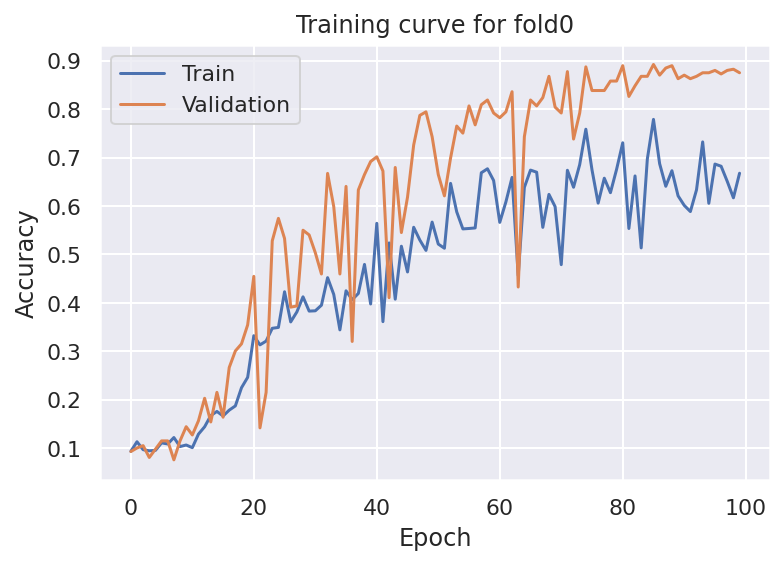

Epoch=0, Train loss=4.61363, Valid loss=21786.31812, Train Accuracy=0.08652, Validation Accuracy=0.09512
Epoch=10, Train loss=2.29444, Valid loss=2.13747, Train Accuracy=0.18801, Validation Accuracy=0.18537
Epoch=20, Train loss=2.28665, Valid loss=2.04313, Train Accuracy=0.22720, Validation Accuracy=0.38049
Epoch=30, Train loss=2.14213, Valid loss=1.71951, Train Accuracy=0.35184, Validation Accuracy=0.59756
Epoch=40, Train loss=1.92735, Valid loss=1.16794, Train Accuracy=0.46115, Validation Accuracy=0.78293
Epoch=50, Train loss=2.06980, Valid loss=1.25753, Train Accuracy=0.41173, Validation Accuracy=0.72195
Epoch=60, Train loss=1.61555, Valid loss=1.01328, Train Accuracy=0.62982, Validation Accuracy=0.77317
Epoch=70, Train loss=1.97832, Valid loss=1.07114, Train Accuracy=0.47331, Validation Accuracy=0.82195
Epoch=80, Train loss=1.57594, Valid loss=0.75440, Train Accuracy=0.65173, Validation Accuracy=0.89268
Epoch=90, Train loss=1.55962, Valid loss=0.77309, Train Accuracy=0.66757, Valid

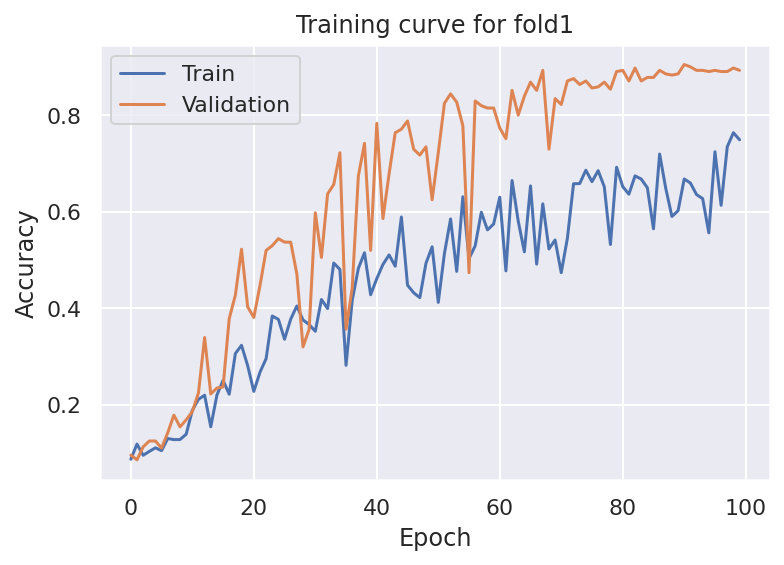

Epoch=0, Train loss=4.65464, Valid loss=2880.09223, Train Accuracy=0.09749, Validation Accuracy=0.10000
Epoch=10, Train loss=2.28671, Valid loss=1.92048, Train Accuracy=0.22579, Validation Accuracy=0.37317
Epoch=20, Train loss=2.02212, Valid loss=1.54092, Train Accuracy=0.40824, Validation Accuracy=0.52439
Epoch=30, Train loss=1.97907, Valid loss=1.87623, Train Accuracy=0.44112, Validation Accuracy=0.37561
Epoch=40, Train loss=1.98919, Valid loss=0.99662, Train Accuracy=0.44586, Validation Accuracy=0.80244
Epoch=50, Train loss=1.72453, Valid loss=0.88954, Train Accuracy=0.58348, Validation Accuracy=0.83171
Epoch=60, Train loss=1.91791, Valid loss=1.15009, Train Accuracy=0.49705, Validation Accuracy=0.78537
Epoch=70, Train loss=1.57113, Valid loss=0.81812, Train Accuracy=0.66462, Validation Accuracy=0.83171
Epoch=80, Train loss=1.71027, Valid loss=0.80880, Train Accuracy=0.60348, Validation Accuracy=0.89512
Epoch=90, Train loss=1.49938, Valid loss=0.73001, Train Accuracy=0.68451, Valida

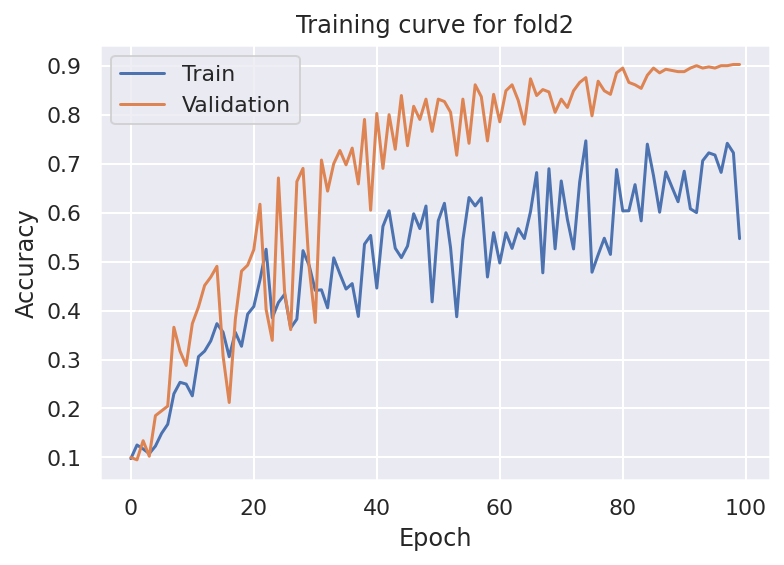

Epoch=0, Train loss=4.07813, Valid loss=918.51482, Train Accuracy=0.09208, Validation Accuracy=0.12439
Epoch=10, Train loss=2.32654, Valid loss=2.13564, Train Accuracy=0.21573, Validation Accuracy=0.32927
Epoch=20, Train loss=1.98866, Valid loss=1.44378, Train Accuracy=0.40380, Validation Accuracy=0.57317
Epoch=30, Train loss=1.83521, Valid loss=1.07080, Train Accuracy=0.51304, Validation Accuracy=0.76098
Epoch=40, Train loss=1.86586, Valid loss=1.21925, Train Accuracy=0.53107, Validation Accuracy=0.74146
Epoch=50, Train loss=1.71607, Valid loss=0.93683, Train Accuracy=0.57659, Validation Accuracy=0.85366
Epoch=60, Train loss=1.73648, Valid loss=0.83338, Train Accuracy=0.58200, Validation Accuracy=0.85122
Epoch=70, Train loss=1.59772, Valid loss=0.77833, Train Accuracy=0.64134, Validation Accuracy=0.86829
Epoch=80, Train loss=1.59512, Valid loss=0.73348, Train Accuracy=0.65087, Validation Accuracy=0.90000
Epoch=90, Train loss=1.79557, Valid loss=0.82273, Train Accuracy=0.55313, Validat

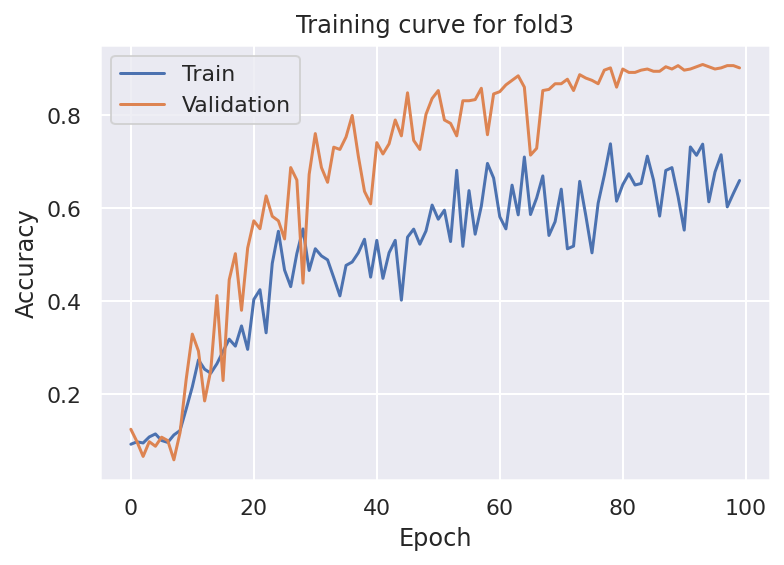

Epoch=0, Train loss=4.26210, Valid loss=3482.44046, Train Accuracy=0.09804, Validation Accuracy=0.11491
Epoch=10, Train loss=2.35835, Valid loss=2.17808, Train Accuracy=0.20261, Validation Accuracy=0.21271
Epoch=20, Train loss=2.11793, Valid loss=1.60105, Train Accuracy=0.36183, Validation Accuracy=0.50122
Epoch=30, Train loss=1.91622, Valid loss=1.32705, Train Accuracy=0.45531, Validation Accuracy=0.61858
Epoch=40, Train loss=1.83609, Valid loss=1.25146, Train Accuracy=0.51833, Validation Accuracy=0.65526
Epoch=50, Train loss=1.74952, Valid loss=1.16485, Train Accuracy=0.55811, Validation Accuracy=0.75061
Epoch=60, Train loss=1.61941, Valid loss=1.19610, Train Accuracy=0.61416, Validation Accuracy=0.75795
Epoch=70, Train loss=1.77501, Valid loss=1.20272, Train Accuracy=0.56407, Validation Accuracy=0.78484
Epoch=80, Train loss=1.69430, Valid loss=0.84272, Train Accuracy=0.60448, Validation Accuracy=0.87286
Epoch=90, Train loss=1.67493, Valid loss=0.79366, Train Accuracy=0.61093, Valida

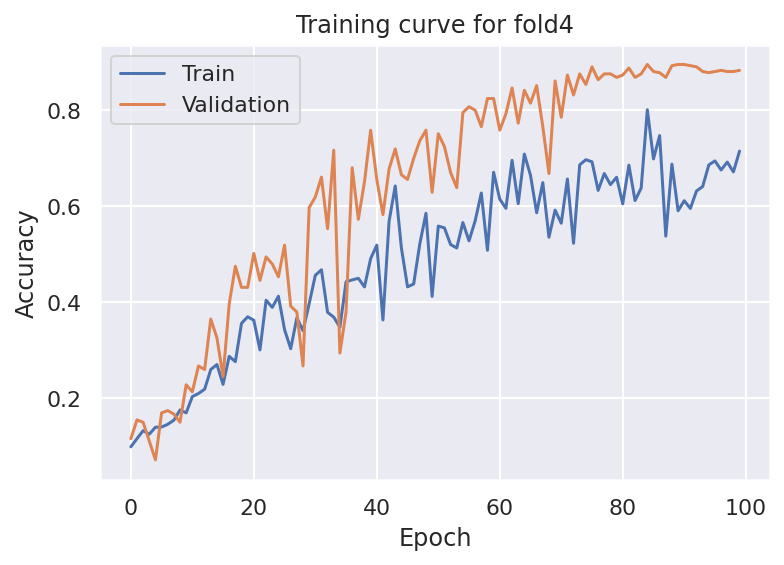

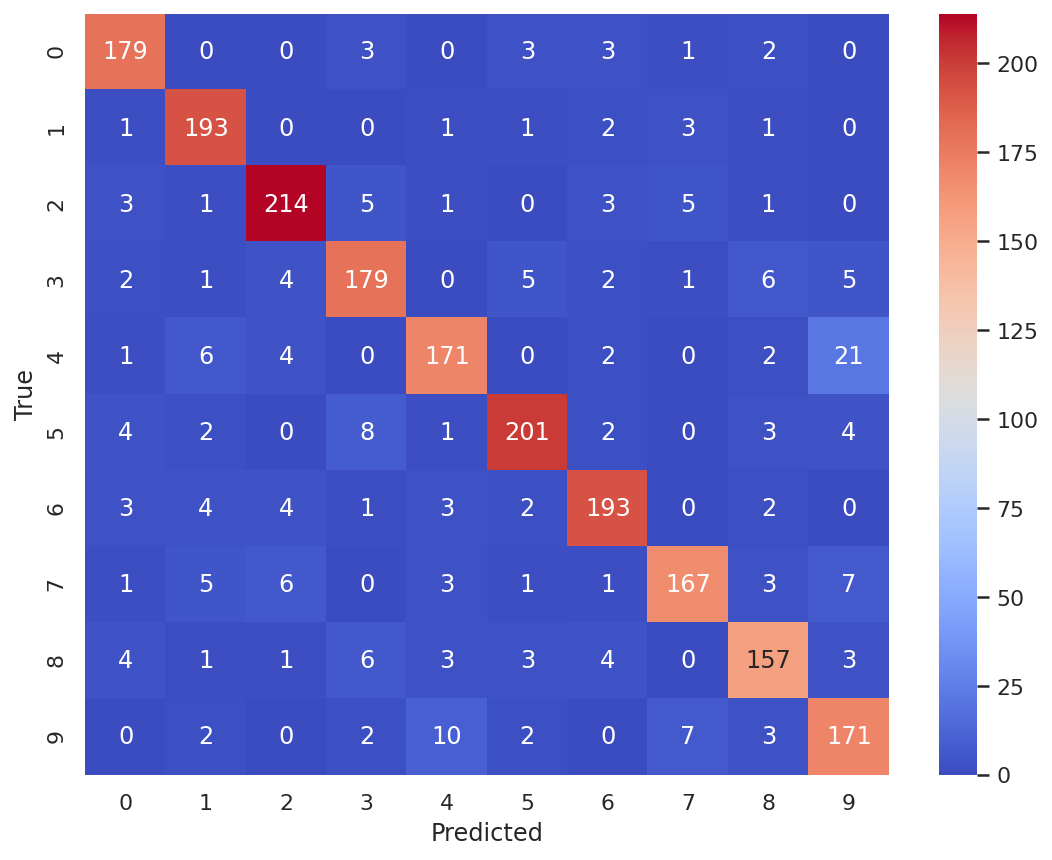

              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       191
         1.0       0.90      0.96      0.93       202
         2.0       0.92      0.92      0.92       233
         3.0       0.88      0.87      0.88       205
         4.0       0.89      0.83      0.85       207
         5.0       0.92      0.89      0.91       225
         6.0       0.91      0.91      0.91       212
         7.0       0.91      0.86      0.88       194
         8.0       0.87      0.86      0.87       182
         9.0       0.81      0.87      0.84       197

    accuracy                           0.89      2048
   macro avg       0.89      0.89      0.89      2048
weighted avg       0.89      0.89      0.89      2048

CV Accuracy Score=0.89111328125
model=resnet34, optimizer=adam, epochs=100, lr=0.003, wd=0.0005
CPU times: user 8min, sys: 55.5 s, total: 8min 56s
Wall time: 9min 29s


In [21]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "adam"
epochs = 100
lr = 3e-3
wd = 5e-4
oof, targs = run(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

### 1.1

Epoch=0, Train loss=4.63888, Valid loss=13395.35032, Train Accuracy=0.10044, Validation Accuracy=0.10024
Epoch=10, Train loss=2.36484, Valid loss=5.11289, Train Accuracy=0.18264, Validation Accuracy=0.12225
Epoch=20, Train loss=2.07415, Valid loss=1.65523, Train Accuracy=0.34439, Validation Accuracy=0.47677
Epoch=30, Train loss=2.11137, Valid loss=1.93884, Train Accuracy=0.38403, Validation Accuracy=0.48655
Epoch=40, Train loss=2.04840, Valid loss=1.41125, Train Accuracy=0.43175, Validation Accuracy=0.68215
Epoch=50, Train loss=1.74775, Valid loss=1.00212, Train Accuracy=0.56018, Validation Accuracy=0.75795
Epoch=60, Train loss=1.62234, Valid loss=0.79021, Train Accuracy=0.62298, Validation Accuracy=0.83863
Epoch=70, Train loss=1.78584, Valid loss=0.95891, Train Accuracy=0.56447, Validation Accuracy=0.84352
Epoch=80, Train loss=1.68347, Valid loss=0.86701, Train Accuracy=0.60769, Validation Accuracy=0.87775
Epoch=90, Train loss=1.58598, Valid loss=0.77261, Train Accuracy=0.65169, Valid

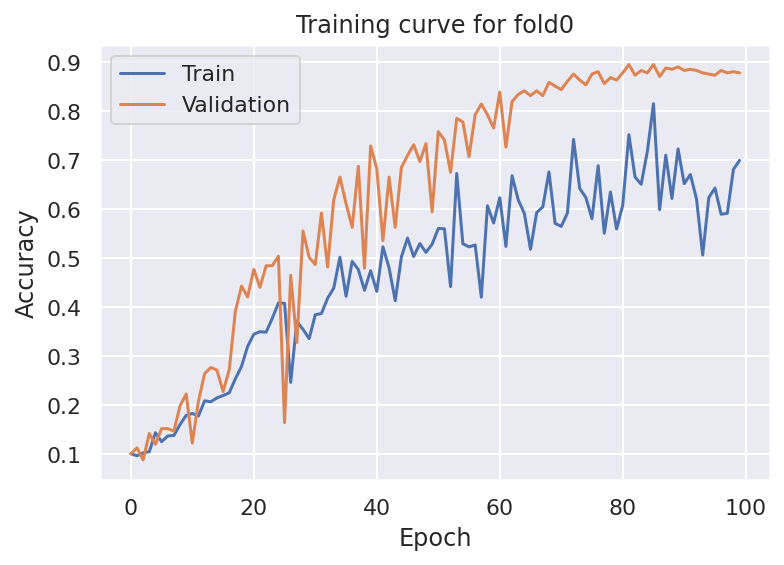

Epoch=0, Train loss=3.87910, Valid loss=8765.53419, Train Accuracy=0.09172, Validation Accuracy=0.06098
Epoch=10, Train loss=2.35702, Valid loss=2.37721, Train Accuracy=0.15226, Validation Accuracy=0.19268
Epoch=20, Train loss=2.27516, Valid loss=2.25161, Train Accuracy=0.22198, Validation Accuracy=0.27561
Epoch=30, Train loss=2.11332, Valid loss=2.80530, Train Accuracy=0.33649, Validation Accuracy=0.21220
Epoch=40, Train loss=1.93395, Valid loss=1.43237, Train Accuracy=0.45673, Validation Accuracy=0.61707
Epoch=50, Train loss=1.80775, Valid loss=0.91470, Train Accuracy=0.53805, Validation Accuracy=0.77317
Epoch=60, Train loss=1.79696, Valid loss=1.47297, Train Accuracy=0.54488, Validation Accuracy=0.65610
Epoch=70, Train loss=1.61938, Valid loss=0.99090, Train Accuracy=0.62620, Validation Accuracy=0.81220
Epoch=80, Train loss=1.55435, Valid loss=0.73984, Train Accuracy=0.66068, Validation Accuracy=0.87805
Epoch=90, Train loss=1.57543, Valid loss=0.69964, Train Accuracy=0.65324, Valida

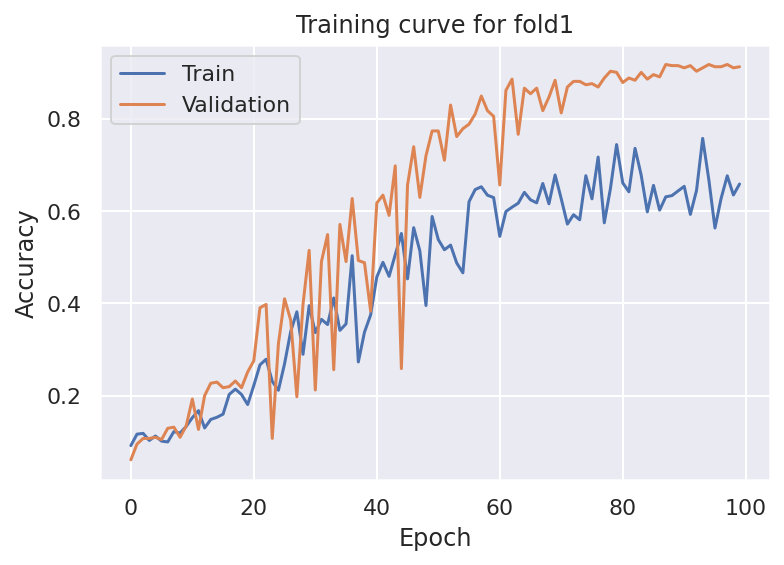

Epoch=0, Train loss=4.29714, Valid loss=4743.15369, Train Accuracy=0.09408, Validation Accuracy=0.09024
Epoch=10, Train loss=2.33644, Valid loss=2.14024, Train Accuracy=0.13732, Validation Accuracy=0.23659
Epoch=20, Train loss=2.12228, Valid loss=10.17418, Train Accuracy=0.33942, Validation Accuracy=0.23902
Epoch=30, Train loss=2.04218, Valid loss=1.61285, Train Accuracy=0.39419, Validation Accuracy=0.50000
Epoch=40, Train loss=1.90367, Valid loss=1.36410, Train Accuracy=0.49615, Validation Accuracy=0.69268
Epoch=50, Train loss=1.69525, Valid loss=1.01159, Train Accuracy=0.59008, Validation Accuracy=0.79512
Epoch=60, Train loss=1.64817, Valid loss=0.84940, Train Accuracy=0.62084, Validation Accuracy=0.80976
Epoch=70, Train loss=1.66918, Valid loss=0.85071, Train Accuracy=0.62174, Validation Accuracy=0.85366
Epoch=80, Train loss=1.52281, Valid loss=0.71319, Train Accuracy=0.67850, Validation Accuracy=0.86585
Epoch=90, Train loss=1.61996, Valid loss=0.75551, Train Accuracy=0.63842, Valid

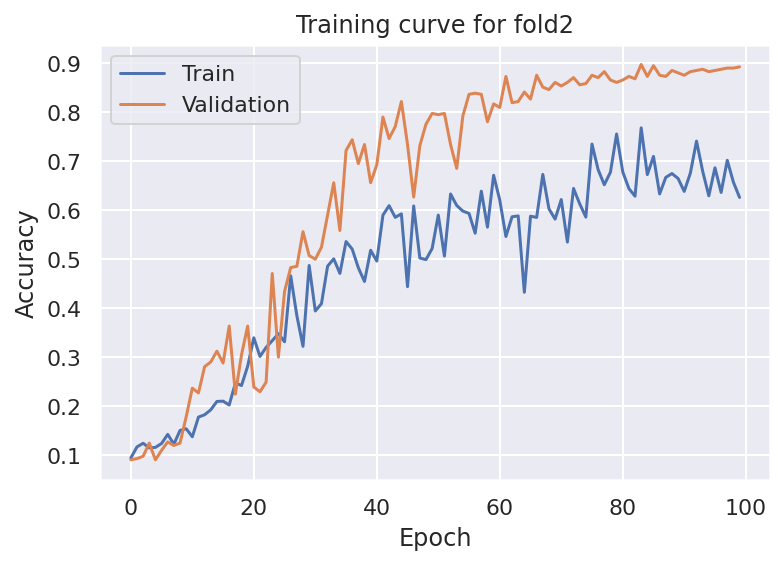

Epoch=0, Train loss=4.52322, Valid loss=2.77394, Train Accuracy=0.09979, Validation Accuracy=0.06341
Epoch=10, Train loss=2.27961, Valid loss=2.21773, Train Accuracy=0.23161, Validation Accuracy=0.30976
Epoch=20, Train loss=2.07365, Valid loss=1.57737, Train Accuracy=0.40545, Validation Accuracy=0.52195
Epoch=30, Train loss=2.05287, Valid loss=1.80298, Train Accuracy=0.39761, Validation Accuracy=0.53171
Epoch=40, Train loss=1.95317, Valid loss=1.22737, Train Accuracy=0.46544, Validation Accuracy=0.69268
Epoch=50, Train loss=1.73492, Valid loss=0.77364, Train Accuracy=0.56506, Validation Accuracy=0.84390
Epoch=60, Train loss=1.85977, Valid loss=1.02815, Train Accuracy=0.52092, Validation Accuracy=0.86341
Epoch=70, Train loss=1.80051, Valid loss=0.89801, Train Accuracy=0.55672, Validation Accuracy=0.87073
Epoch=80, Train loss=1.60994, Valid loss=0.74637, Train Accuracy=0.63624, Validation Accuracy=0.89024
Epoch=90, Train loss=1.78723, Valid loss=0.76425, Train Accuracy=0.56160, Validatio

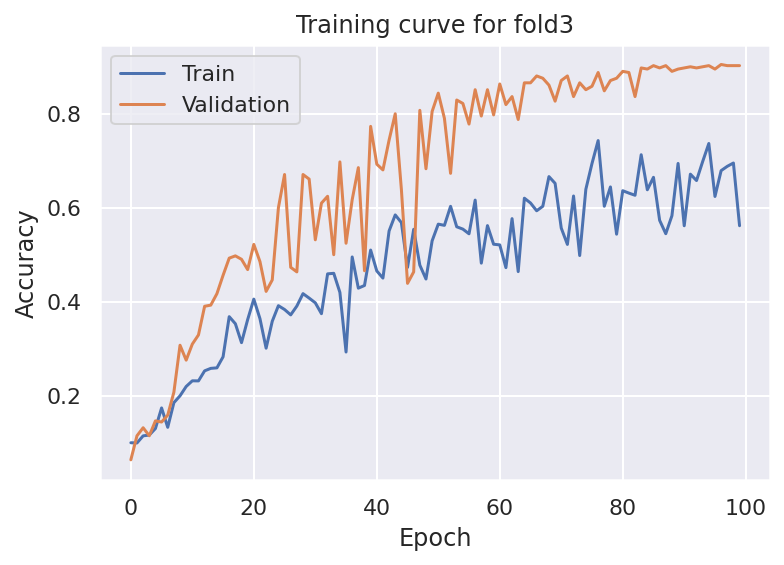

Epoch=0, Train loss=4.46541, Valid loss=21374.81981, Train Accuracy=0.10406, Validation Accuracy=0.10024
Epoch=10, Train loss=2.33029, Valid loss=2.25247, Train Accuracy=0.22771, Validation Accuracy=0.19804
Epoch=20, Train loss=2.01705, Valid loss=1.67745, Train Accuracy=0.41513, Validation Accuracy=0.50611
Epoch=30, Train loss=2.06831, Valid loss=2.86915, Train Accuracy=0.37046, Validation Accuracy=0.35941
Epoch=40, Train loss=1.95092, Valid loss=1.55110, Train Accuracy=0.46346, Validation Accuracy=0.53790
Epoch=50, Train loss=1.96952, Valid loss=1.08720, Train Accuracy=0.44408, Validation Accuracy=0.78729
Epoch=60, Train loss=1.61823, Valid loss=0.94143, Train Accuracy=0.63812, Validation Accuracy=0.82152
Epoch=70, Train loss=1.70925, Valid loss=1.23105, Train Accuracy=0.58911, Validation Accuracy=0.76284
Epoch=80, Train loss=1.67255, Valid loss=0.80526, Train Accuracy=0.60898, Validation Accuracy=0.86308
Epoch=90, Train loss=1.95236, Valid loss=0.94490, Train Accuracy=0.49258, Valid

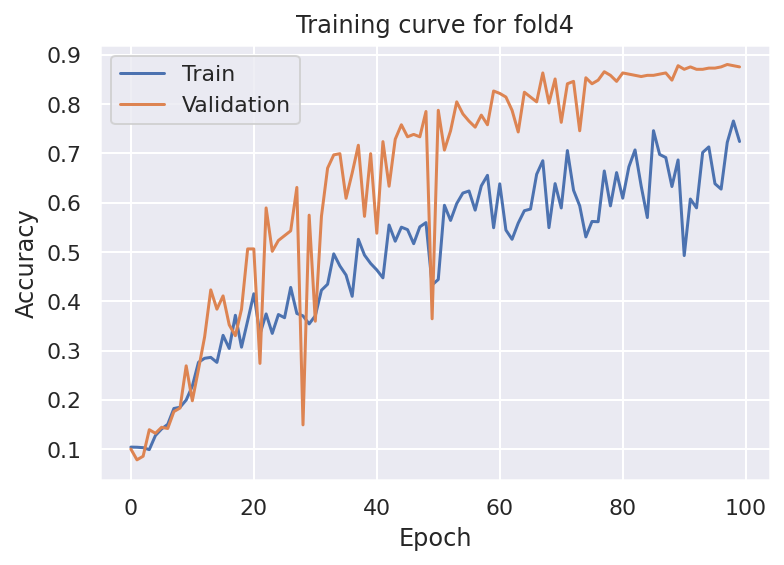

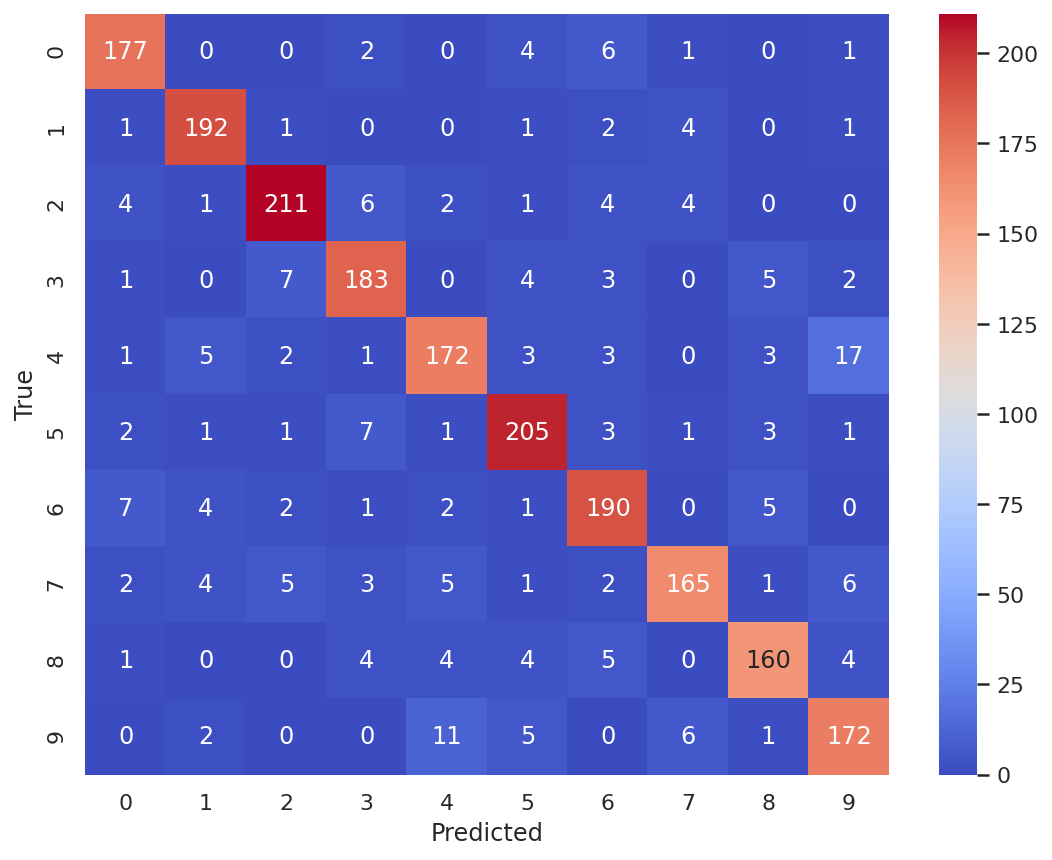

              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91       191
         1.0       0.92      0.95      0.93       202
         2.0       0.92      0.91      0.91       233
         3.0       0.88      0.89      0.89       205
         4.0       0.87      0.83      0.85       207
         5.0       0.90      0.91      0.90       225
         6.0       0.87      0.90      0.88       212
         7.0       0.91      0.85      0.88       194
         8.0       0.90      0.88      0.89       182
         9.0       0.84      0.87      0.86       197

    accuracy                           0.89      2048
   macro avg       0.89      0.89      0.89      2048
weighted avg       0.89      0.89      0.89      2048

CV Accuracy Score=0.89208984375
model=resnet34, optimizer=adam, epochs=100, lr=0.003, wd=0.0005
CPU times: user 8min 1s, sys: 55.1 s, total: 8min 56s
Wall time: 9min 29s


In [22]:
%%time
# With scaling
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "adam"
epochs = 100
lr = 3e-3
wd = 5e-4
oof, targs = run(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

### 1.2

Epoch=0, Train loss=2.89014, Valid loss=2.22944, Train Accuracy=0.12039, Validation Accuracy=0.13692
Epoch=10, Train loss=1.99330, Valid loss=2.21154, Train Accuracy=0.43569, Validation Accuracy=0.19071
Epoch=20, Train loss=2.10465, Valid loss=1.73553, Train Accuracy=0.43873, Validation Accuracy=0.50367
Epoch=30, Train loss=1.68626, Valid loss=1.26733, Train Accuracy=0.61502, Validation Accuracy=0.66015
Epoch=40, Train loss=1.51615, Valid loss=1.01355, Train Accuracy=0.70269, Validation Accuracy=0.75550
Epoch=50, Train loss=1.41043, Valid loss=0.72664, Train Accuracy=0.73808, Validation Accuracy=0.85086
Epoch=60, Train loss=1.89585, Valid loss=1.04053, Train Accuracy=0.53173, Validation Accuracy=0.79951
Epoch=70, Train loss=1.63782, Valid loss=0.88340, Train Accuracy=0.63932, Validation Accuracy=0.85575
Epoch=80, Train loss=1.43326, Valid loss=0.74626, Train Accuracy=0.72723, Validation Accuracy=0.89731
Epoch=90, Train loss=1.35378, Valid loss=0.76353, Train Accuracy=0.74526, Validatio

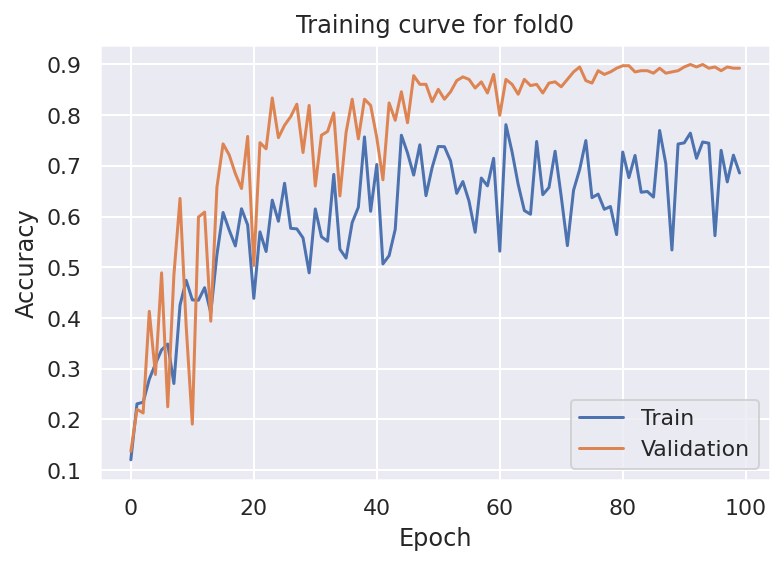

Epoch=0, Train loss=4.04853, Valid loss=6.02057, Train Accuracy=0.13489, Validation Accuracy=0.16829
Epoch=10, Train loss=2.01853, Valid loss=1.19131, Train Accuracy=0.40774, Validation Accuracy=0.65122
Epoch=20, Train loss=1.98389, Valid loss=2.02925, Train Accuracy=0.45997, Validation Accuracy=0.69512
Epoch=30, Train loss=1.94502, Valid loss=1.09993, Train Accuracy=0.48339, Validation Accuracy=0.75610
Epoch=40, Train loss=1.68221, Valid loss=0.83442, Train Accuracy=0.62497, Validation Accuracy=0.83171
Epoch=50, Train loss=1.70947, Valid loss=0.96362, Train Accuracy=0.60549, Validation Accuracy=0.81951
Epoch=60, Train loss=1.46364, Valid loss=0.73291, Train Accuracy=0.70570, Validation Accuracy=0.87805
Epoch=70, Train loss=1.64840, Valid loss=0.82014, Train Accuracy=0.63638, Validation Accuracy=0.87073
Epoch=80, Train loss=1.88079, Valid loss=0.86911, Train Accuracy=0.54063, Validation Accuracy=0.88049
Epoch=90, Train loss=1.64843, Valid loss=0.73085, Train Accuracy=0.62034, Validatio

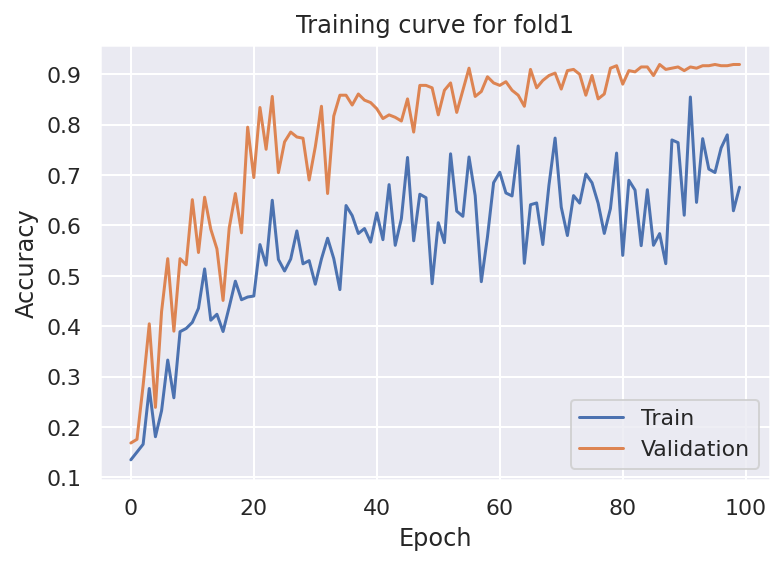

Epoch=0, Train loss=3.23942, Valid loss=2.38127, Train Accuracy=0.12342, Validation Accuracy=0.13659
Epoch=10, Train loss=1.84140, Valid loss=1.10370, Train Accuracy=0.49191, Validation Accuracy=0.64634
Epoch=20, Train loss=1.78066, Valid loss=0.73282, Train Accuracy=0.54794, Validation Accuracy=0.85122
Epoch=30, Train loss=1.71001, Valid loss=0.98300, Train Accuracy=0.60293, Validation Accuracy=0.78780
Epoch=40, Train loss=1.63317, Valid loss=1.25865, Train Accuracy=0.65263, Validation Accuracy=0.70732
Epoch=50, Train loss=1.53939, Valid loss=0.73502, Train Accuracy=0.69190, Validation Accuracy=0.87317
Epoch=60, Train loss=1.45608, Valid loss=0.74164, Train Accuracy=0.70735, Validation Accuracy=0.88049
Epoch=70, Train loss=1.57148, Valid loss=0.73822, Train Accuracy=0.66564, Validation Accuracy=0.89024
Epoch=80, Train loss=1.76110, Valid loss=0.87259, Train Accuracy=0.57654, Validation Accuracy=0.87805
Epoch=90, Train loss=1.72332, Valid loss=0.78943, Train Accuracy=0.59111, Validatio

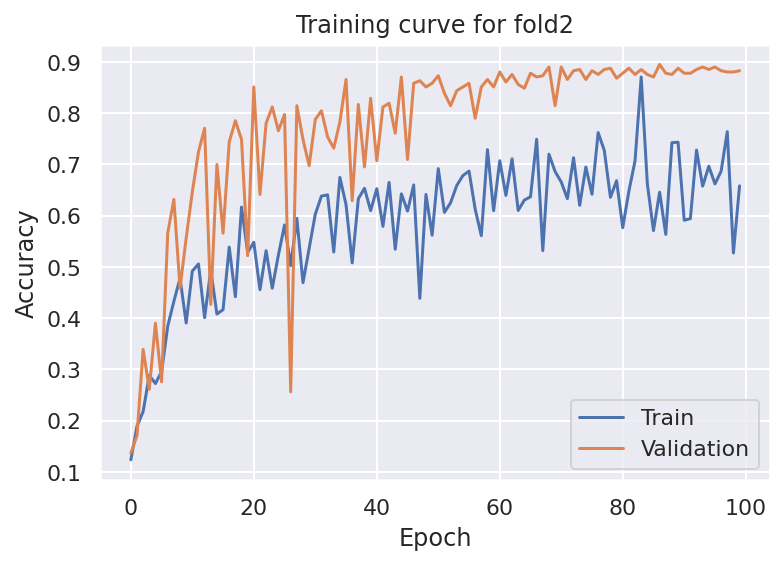

Epoch=0, Train loss=2.61648, Valid loss=2.18700, Train Accuracy=0.12715, Validation Accuracy=0.19512
Epoch=10, Train loss=2.24644, Valid loss=1.71936, Train Accuracy=0.34635, Validation Accuracy=0.38537
Epoch=20, Train loss=2.00698, Valid loss=1.11608, Train Accuracy=0.45018, Validation Accuracy=0.70244
Epoch=30, Train loss=1.88429, Valid loss=1.02248, Train Accuracy=0.51662, Validation Accuracy=0.74146
Epoch=40, Train loss=1.57557, Valid loss=0.96034, Train Accuracy=0.67730, Validation Accuracy=0.81951
Epoch=50, Train loss=1.43891, Valid loss=0.73860, Train Accuracy=0.72950, Validation Accuracy=0.87561
Epoch=60, Train loss=1.39444, Valid loss=0.72463, Train Accuracy=0.74159, Validation Accuracy=0.88537
Epoch=70, Train loss=1.53371, Valid loss=0.76632, Train Accuracy=0.68555, Validation Accuracy=0.87805
Epoch=80, Train loss=1.50104, Valid loss=0.74112, Train Accuracy=0.68422, Validation Accuracy=0.88537
Epoch=90, Train loss=1.57794, Valid loss=0.68913, Train Accuracy=0.65784, Validatio

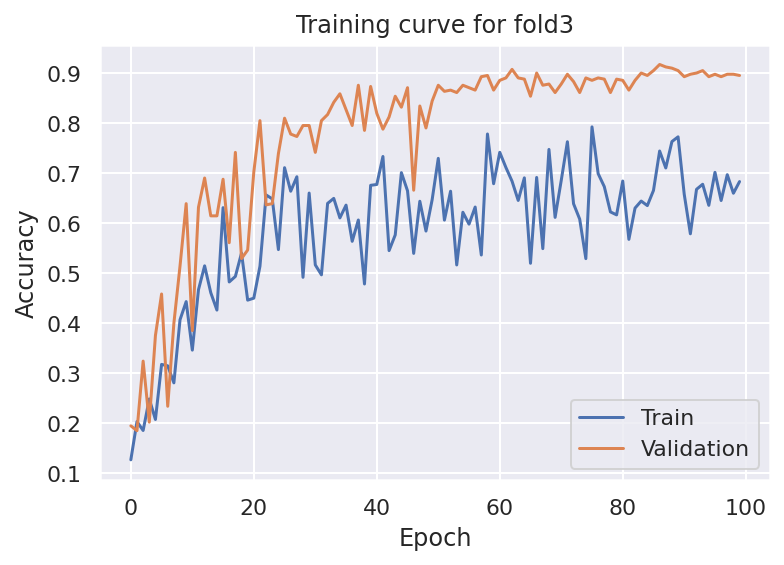

Epoch=0, Train loss=2.68577, Valid loss=2.57125, Train Accuracy=0.15997, Validation Accuracy=0.12958
Epoch=10, Train loss=1.94744, Valid loss=1.29773, Train Accuracy=0.44579, Validation Accuracy=0.59658
Epoch=20, Train loss=2.07040, Valid loss=1.15311, Train Accuracy=0.40877, Validation Accuracy=0.65526
Epoch=30, Train loss=1.83176, Valid loss=1.27496, Train Accuracy=0.55879, Validation Accuracy=0.70905
Epoch=40, Train loss=1.56137, Valid loss=0.93153, Train Accuracy=0.67475, Validation Accuracy=0.80440
Epoch=50, Train loss=1.86905, Valid loss=1.06445, Train Accuracy=0.54106, Validation Accuracy=0.83619
Epoch=60, Train loss=1.60162, Valid loss=0.90511, Train Accuracy=0.65607, Validation Accuracy=0.84352
Epoch=70, Train loss=1.66457, Valid loss=0.92447, Train Accuracy=0.62183, Validation Accuracy=0.86308
Epoch=80, Train loss=1.20482, Valid loss=0.68661, Train Accuracy=0.80674, Validation Accuracy=0.89731
Epoch=90, Train loss=1.42957, Valid loss=0.83051, Train Accuracy=0.71922, Validatio

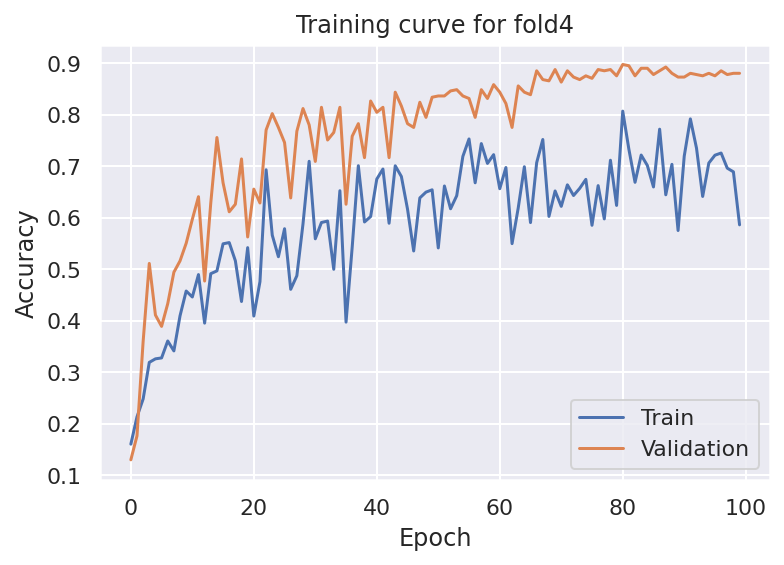

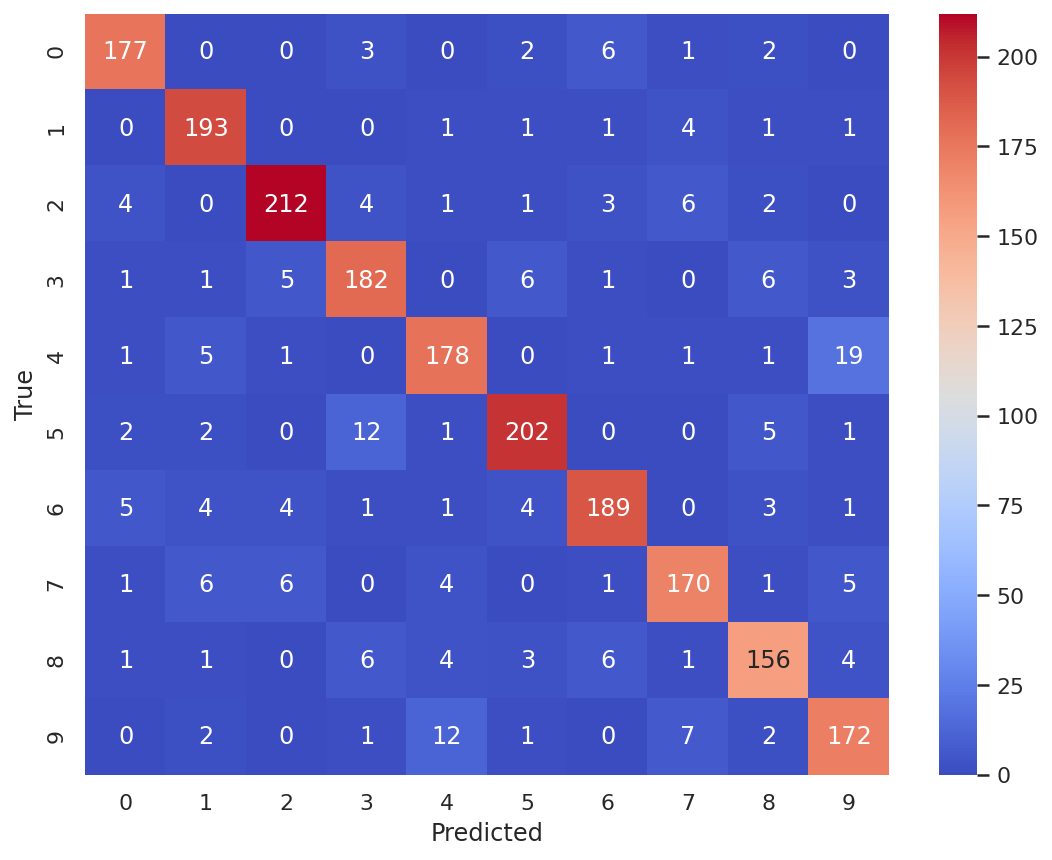

              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92       191
         1.0       0.90      0.96      0.93       202
         2.0       0.93      0.91      0.92       233
         3.0       0.87      0.89      0.88       205
         4.0       0.88      0.86      0.87       207
         5.0       0.92      0.90      0.91       225
         6.0       0.91      0.89      0.90       212
         7.0       0.89      0.88      0.89       194
         8.0       0.87      0.86      0.86       182
         9.0       0.83      0.87      0.85       197

    accuracy                           0.89      2048
   macro avg       0.89      0.89      0.89      2048
weighted avg       0.89      0.89      0.89      2048

CV Accuracy Score=0.89404296875
model=resnet34, optimizer=radam, epochs=100, lr=0.003, wd=0.0005
CPU times: user 7min 57s, sys: 55.4 s, total: 8min 52s
Wall time: 9min 25s


In [23]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0., rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "radam"
epochs = 100
lr = 3e-3
wd = 5e-4
oof, targs = run(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

### 1.3

Epoch=0, Train loss=2.58889, Valid loss=2.56613, Train Accuracy=0.13899, Validation Accuracy=0.13936
Epoch=10, Train loss=1.98644, Valid loss=1.36924, Train Accuracy=0.44816, Validation Accuracy=0.58924
Epoch=20, Train loss=1.71916, Valid loss=0.97937, Train Accuracy=0.57945, Validation Accuracy=0.73105
Epoch=30, Train loss=1.83807, Valid loss=0.93829, Train Accuracy=0.53893, Validation Accuracy=0.83863
Epoch=40, Train loss=1.54177, Valid loss=0.79962, Train Accuracy=0.67925, Validation Accuracy=0.81418
Epoch=50, Train loss=1.60984, Valid loss=0.72299, Train Accuracy=0.64281, Validation Accuracy=0.87775
Epoch=60, Train loss=1.53607, Valid loss=0.71955, Train Accuracy=0.69831, Validation Accuracy=0.84841
Epoch=70, Train loss=1.29711, Valid loss=0.68785, Train Accuracy=0.77283, Validation Accuracy=0.87042
Epoch=80, Train loss=1.60898, Valid loss=0.78133, Train Accuracy=0.64797, Validation Accuracy=0.88509
Epoch=90, Train loss=1.73896, Valid loss=0.85691, Train Accuracy=0.57999, Validatio

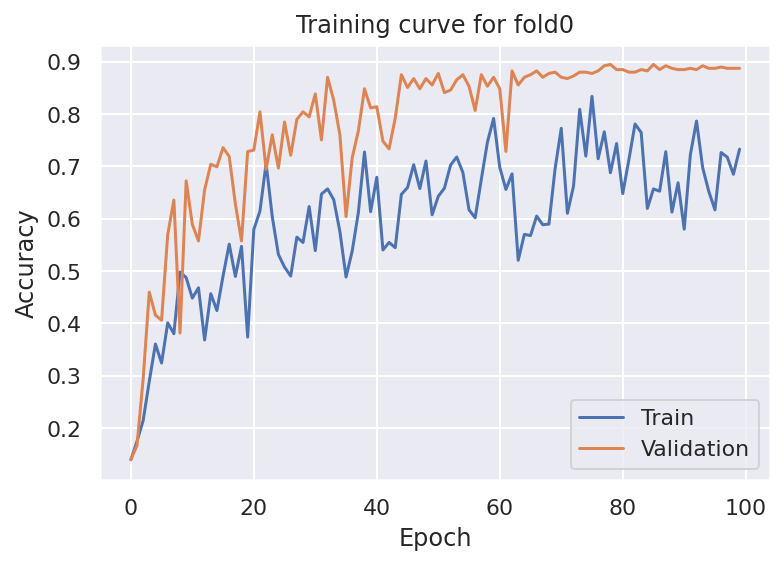

Epoch=0, Train loss=3.04373, Valid loss=2.22090, Train Accuracy=0.13131, Validation Accuracy=0.20976
Epoch=10, Train loss=1.98231, Valid loss=1.19301, Train Accuracy=0.43720, Validation Accuracy=0.67073
Epoch=20, Train loss=2.12393, Valid loss=1.34774, Train Accuracy=0.38034, Validation Accuracy=0.66585
Epoch=30, Train loss=1.55774, Valid loss=1.10857, Train Accuracy=0.66508, Validation Accuracy=0.74634
Epoch=40, Train loss=1.86902, Valid loss=1.28843, Train Accuracy=0.54111, Validation Accuracy=0.72195
Epoch=50, Train loss=1.44671, Valid loss=0.68700, Train Accuracy=0.72880, Validation Accuracy=0.85854
Epoch=60, Train loss=1.40065, Valid loss=0.66674, Train Accuracy=0.73010, Validation Accuracy=0.89512
Epoch=70, Train loss=1.36865, Valid loss=0.67322, Train Accuracy=0.75594, Validation Accuracy=0.89268
Epoch=80, Train loss=1.55039, Valid loss=0.76539, Train Accuracy=0.67358, Validation Accuracy=0.90488
Epoch=90, Train loss=1.54993, Valid loss=0.77568, Train Accuracy=0.66745, Validatio

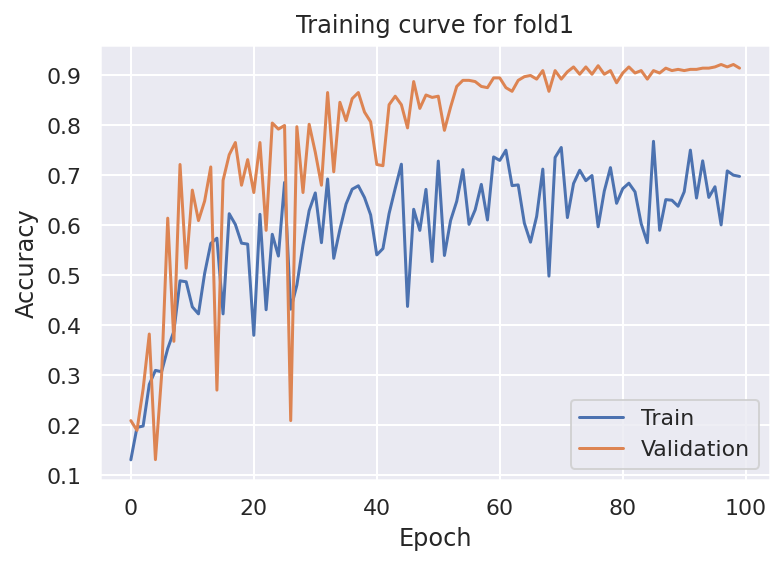

Epoch=0, Train loss=3.11905, Valid loss=2.30081, Train Accuracy=0.13153, Validation Accuracy=0.18537
Epoch=10, Train loss=2.01749, Valid loss=10.91591, Train Accuracy=0.43334, Validation Accuracy=0.19024
Epoch=20, Train loss=1.81577, Valid loss=0.98722, Train Accuracy=0.52748, Validation Accuracy=0.77805
Epoch=30, Train loss=1.73407, Valid loss=1.01856, Train Accuracy=0.59172, Validation Accuracy=0.81463
Epoch=40, Train loss=1.80350, Valid loss=1.29267, Train Accuracy=0.57656, Validation Accuracy=0.77073
Epoch=50, Train loss=1.52256, Valid loss=0.65278, Train Accuracy=0.69981, Validation Accuracy=0.87561
Epoch=60, Train loss=1.53121, Valid loss=0.73533, Train Accuracy=0.68257, Validation Accuracy=0.86585
Epoch=70, Train loss=1.82068, Valid loss=0.94801, Train Accuracy=0.56053, Validation Accuracy=0.86829
Epoch=80, Train loss=1.68897, Valid loss=0.81104, Train Accuracy=0.61821, Validation Accuracy=0.88537
Epoch=90, Train loss=1.49259, Valid loss=0.73868, Train Accuracy=0.68943, Validati

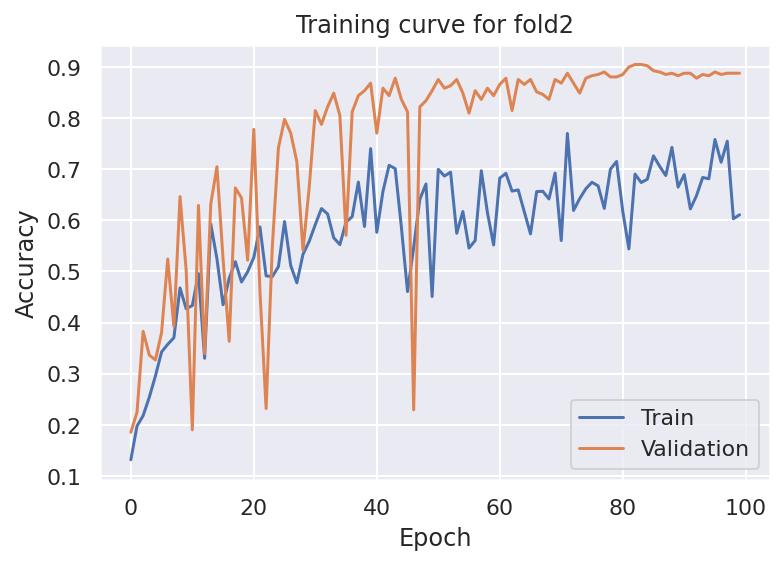

Epoch=0, Train loss=2.94317, Valid loss=2.28610, Train Accuracy=0.13599, Validation Accuracy=0.14146
Epoch=10, Train loss=1.80420, Valid loss=1.03499, Train Accuracy=0.52770, Validation Accuracy=0.71463
Epoch=20, Train loss=1.80046, Valid loss=0.92420, Train Accuracy=0.55199, Validation Accuracy=0.80976
Epoch=30, Train loss=1.50079, Valid loss=0.78894, Train Accuracy=0.69086, Validation Accuracy=0.82195
Epoch=40, Train loss=1.52580, Valid loss=0.74621, Train Accuracy=0.68641, Validation Accuracy=0.86341
Epoch=50, Train loss=1.55260, Valid loss=0.85370, Train Accuracy=0.68060, Validation Accuracy=0.86585
Epoch=60, Train loss=1.59798, Valid loss=0.86142, Train Accuracy=0.65636, Validation Accuracy=0.88780
Epoch=70, Train loss=1.72706, Valid loss=0.89663, Train Accuracy=0.60714, Validation Accuracy=0.90000
Epoch=80, Train loss=1.25794, Valid loss=0.67515, Train Accuracy=0.78654, Validation Accuracy=0.89268
Epoch=90, Train loss=1.44319, Valid loss=0.69273, Train Accuracy=0.70791, Validatio

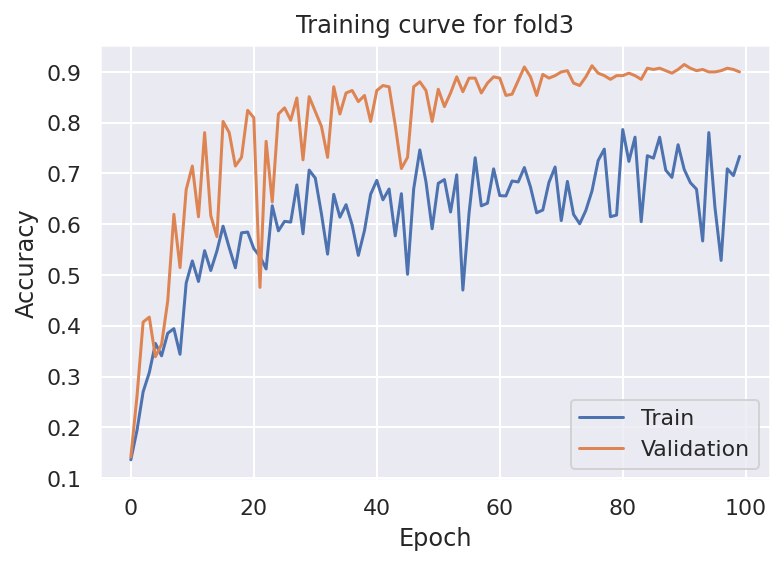

Epoch=0, Train loss=3.14981, Valid loss=2.44405, Train Accuracy=0.12891, Validation Accuracy=0.20049
Epoch=10, Train loss=2.14730, Valid loss=1.59459, Train Accuracy=0.32349, Validation Accuracy=0.51834
Epoch=20, Train loss=1.94396, Valid loss=1.69921, Train Accuracy=0.47616, Validation Accuracy=0.62592
Epoch=30, Train loss=1.82942, Valid loss=1.22799, Train Accuracy=0.53808, Validation Accuracy=0.62103
Epoch=40, Train loss=1.68019, Valid loss=0.82914, Train Accuracy=0.61612, Validation Accuracy=0.85330
Epoch=50, Train loss=1.60540, Valid loss=0.93320, Train Accuracy=0.65849, Validation Accuracy=0.85330
Epoch=60, Train loss=1.90874, Valid loss=1.11664, Train Accuracy=0.51870, Validation Accuracy=0.81907
Epoch=70, Train loss=1.59151, Valid loss=0.85903, Train Accuracy=0.66106, Validation Accuracy=0.87042
Epoch=80, Train loss=1.55003, Valid loss=0.81750, Train Accuracy=0.67090, Validation Accuracy=0.87042
Epoch=90, Train loss=1.69087, Valid loss=0.85411, Train Accuracy=0.60752, Validatio

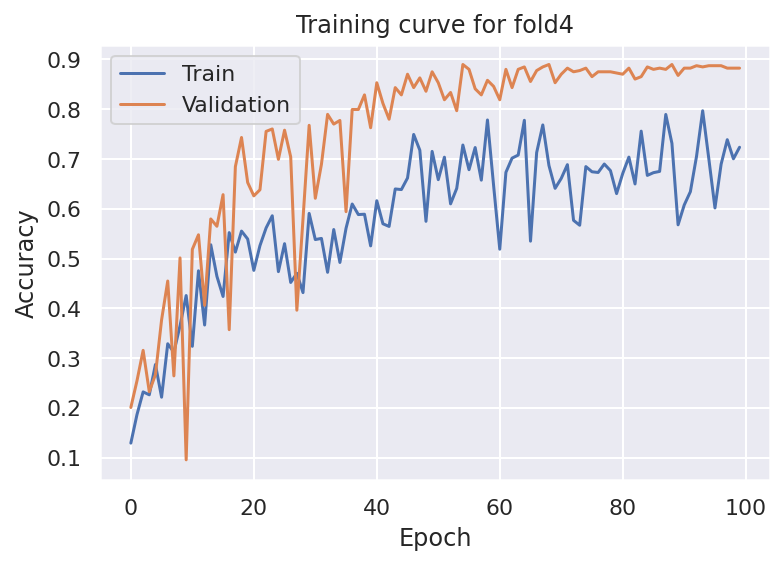

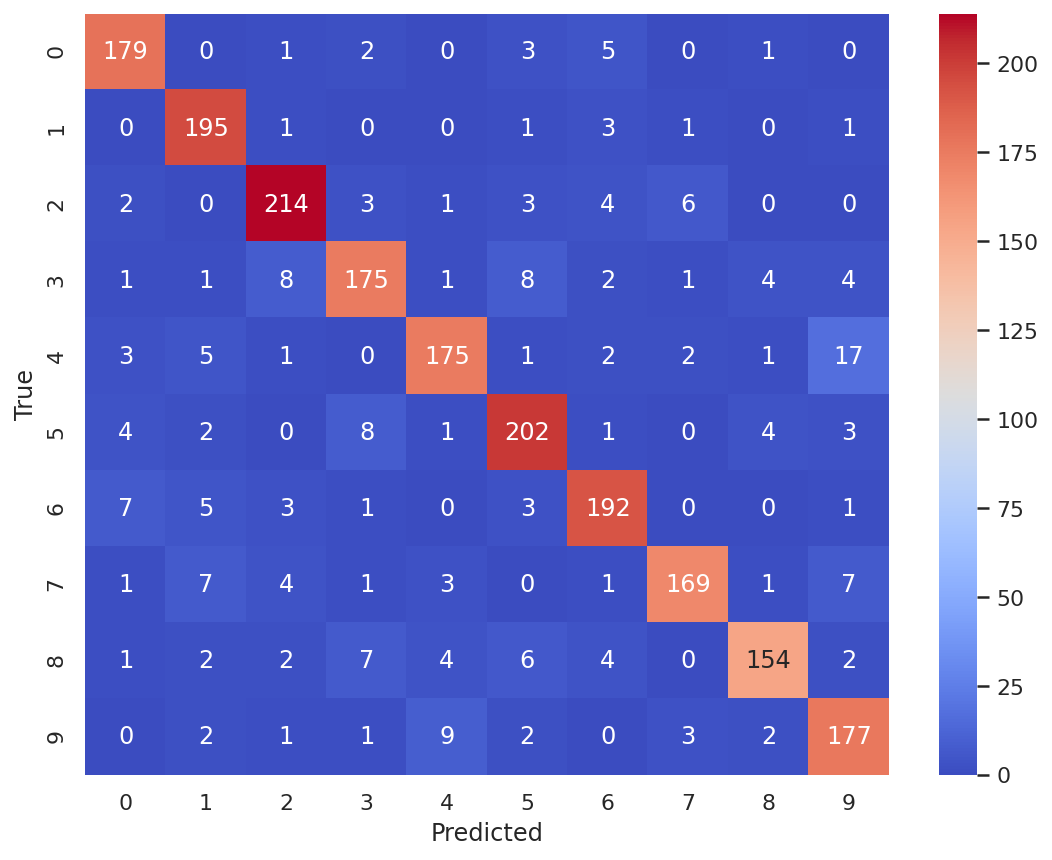

              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       191
         1.0       0.89      0.97      0.93       202
         2.0       0.91      0.92      0.91       233
         3.0       0.88      0.85      0.87       205
         4.0       0.90      0.85      0.87       207
         5.0       0.88      0.90      0.89       225
         6.0       0.90      0.91      0.90       212
         7.0       0.93      0.87      0.90       194
         8.0       0.92      0.85      0.88       182
         9.0       0.83      0.90      0.87       197

    accuracy                           0.89      2048
   macro avg       0.90      0.89      0.89      2048
weighted avg       0.90      0.89      0.89      2048

CV Accuracy Score=0.89453125
model=resnet34, optimizer=radam, epochs=100, lr=0.003, wd=0.0005
CPU times: user 7min 57s, sys: 54.7 s, total: 8min 51s
Wall time: 9min 24s


In [25]:
%%time
# With Scaling
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "radam"
epochs = 100
lr = 3e-3
wd = 5e-4
oof, targs = run(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

### 2.0

Epoch=0, Train loss=2.29708, Valid loss=2.30032, Train Accuracy=0.13113, Validation Accuracy=0.13447
Epoch=10, Train loss=1.83151, Valid loss=1.53091, Train Accuracy=0.48000, Validation Accuracy=0.49878
Epoch=20, Train loss=1.82627, Valid loss=1.20282, Train Accuracy=0.53913, Validation Accuracy=0.69193
Epoch=30, Train loss=1.57804, Valid loss=1.15659, Train Accuracy=0.66148, Validation Accuracy=0.63570
Epoch=40, Train loss=1.66983, Valid loss=0.98603, Train Accuracy=0.63456, Validation Accuracy=0.78729
Epoch=50, Train loss=1.46890, Valid loss=0.90175, Train Accuracy=0.71774, Validation Accuracy=0.81174
Epoch=60, Train loss=1.83757, Valid loss=1.14664, Train Accuracy=0.55087, Validation Accuracy=0.79951
Epoch=70, Train loss=1.59087, Valid loss=1.00489, Train Accuracy=0.67778, Validation Accuracy=0.80929
Epoch=80, Train loss=1.62719, Valid loss=0.99256, Train Accuracy=0.64192, Validation Accuracy=0.82641
Epoch=90, Train loss=1.85579, Valid loss=1.23041, Train Accuracy=0.54305, Validatio

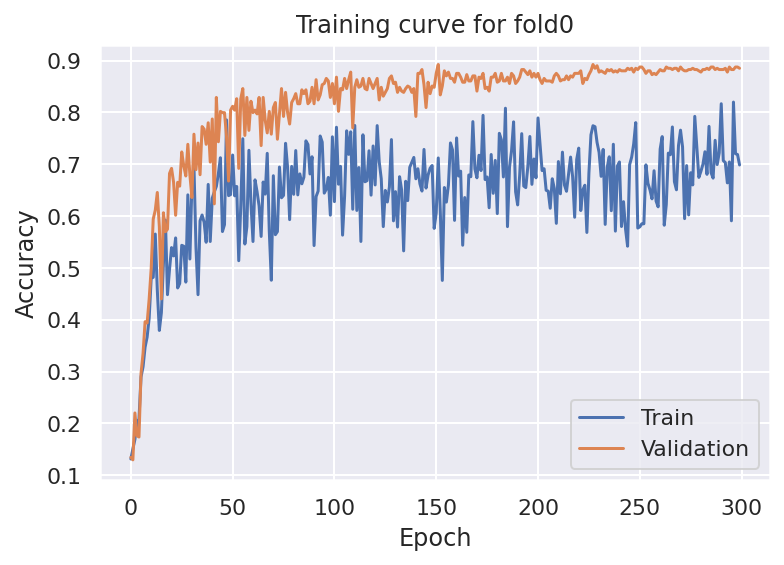

Epoch=0, Train loss=2.30118, Valid loss=2.29948, Train Accuracy=0.10824, Validation Accuracy=0.15122
Epoch=10, Train loss=2.08576, Valid loss=1.69143, Train Accuracy=0.34067, Validation Accuracy=0.50244
Epoch=20, Train loss=1.88619, Valid loss=1.29083, Train Accuracy=0.51106, Validation Accuracy=0.67805
Epoch=30, Train loss=1.64030, Valid loss=1.04004, Train Accuracy=0.64341, Validation Accuracy=0.78780
Epoch=40, Train loss=1.57718, Valid loss=0.92525, Train Accuracy=0.66971, Validation Accuracy=0.82927
Epoch=50, Train loss=1.50003, Valid loss=0.81954, Train Accuracy=0.70048, Validation Accuracy=0.82195
Epoch=60, Train loss=1.68821, Valid loss=1.16020, Train Accuracy=0.62146, Validation Accuracy=0.79024
Epoch=70, Train loss=1.38295, Valid loss=0.90829, Train Accuracy=0.74811, Validation Accuracy=0.82927
Epoch=80, Train loss=1.71583, Valid loss=1.18086, Train Accuracy=0.60825, Validation Accuracy=0.81951
Epoch=90, Train loss=1.73505, Valid loss=0.87970, Train Accuracy=0.60673, Validatio

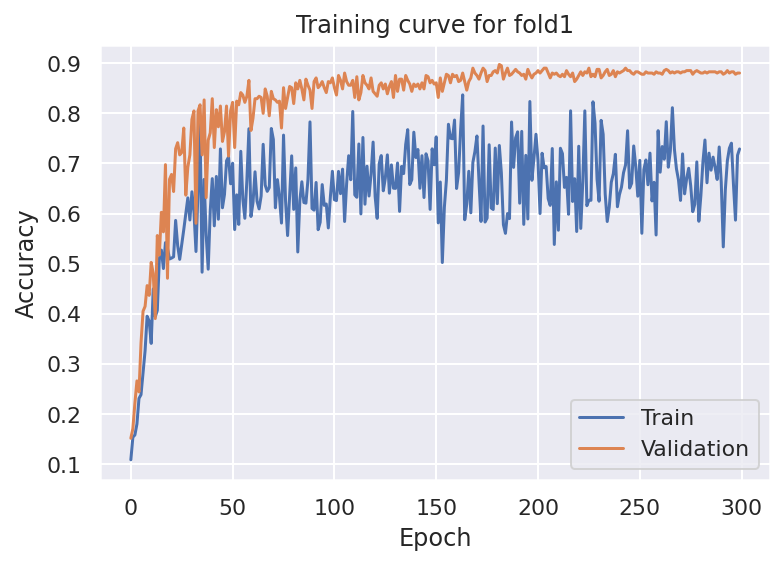

Epoch=0, Train loss=2.29899, Valid loss=2.30130, Train Accuracy=0.11715, Validation Accuracy=0.09024
Epoch=10, Train loss=2.05931, Valid loss=1.81700, Train Accuracy=0.36060, Validation Accuracy=0.37561
Epoch=20, Train loss=1.74706, Valid loss=1.05856, Train Accuracy=0.57021, Validation Accuracy=0.70732
Epoch=30, Train loss=1.84033, Valid loss=1.07480, Train Accuracy=0.54519, Validation Accuracy=0.73171
Epoch=40, Train loss=1.78299, Valid loss=0.99321, Train Accuracy=0.57975, Validation Accuracy=0.74634
Epoch=50, Train loss=1.75094, Valid loss=1.01129, Train Accuracy=0.58720, Validation Accuracy=0.82195
Epoch=60, Train loss=1.79891, Valid loss=1.36504, Train Accuracy=0.57287, Validation Accuracy=0.69512
Epoch=70, Train loss=1.50408, Valid loss=0.76426, Train Accuracy=0.71007, Validation Accuracy=0.88293
Epoch=80, Train loss=1.71693, Valid loss=0.98595, Train Accuracy=0.60874, Validation Accuracy=0.85366
Epoch=90, Train loss=1.56654, Valid loss=0.88481, Train Accuracy=0.67265, Validatio

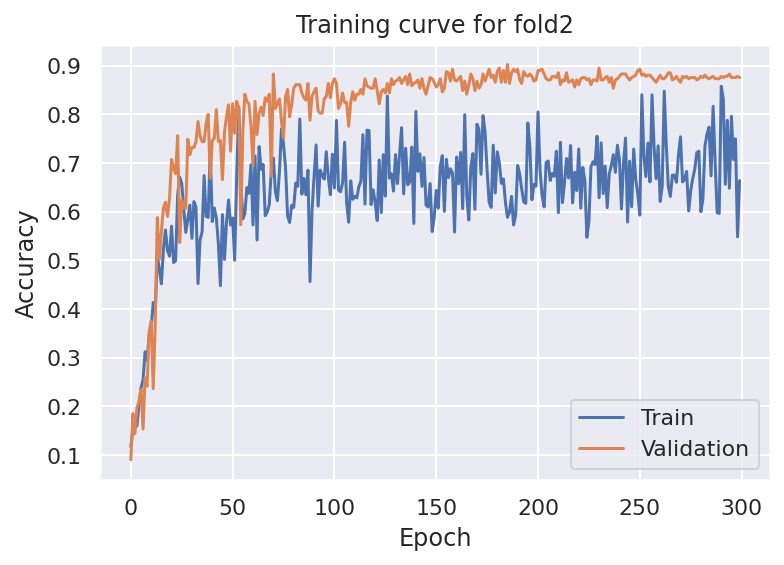

Epoch=0, Train loss=2.29700, Valid loss=2.29972, Train Accuracy=0.10522, Validation Accuracy=0.13902
Epoch=10, Train loss=1.96701, Valid loss=1.48122, Train Accuracy=0.41327, Validation Accuracy=0.54878
Epoch=20, Train loss=1.85011, Valid loss=1.26281, Train Accuracy=0.53139, Validation Accuracy=0.73902
Epoch=30, Train loss=1.81199, Valid loss=1.56880, Train Accuracy=0.55010, Validation Accuracy=0.52195
Epoch=40, Train loss=1.90365, Valid loss=1.08410, Train Accuracy=0.51198, Validation Accuracy=0.76585
Epoch=50, Train loss=1.68226, Valid loss=1.07210, Train Accuracy=0.62644, Validation Accuracy=0.75610
Epoch=60, Train loss=1.68843, Valid loss=0.89089, Train Accuracy=0.63481, Validation Accuracy=0.86341
Epoch=70, Train loss=1.86662, Valid loss=1.09697, Train Accuracy=0.55862, Validation Accuracy=0.77317
Epoch=80, Train loss=1.66302, Valid loss=0.94949, Train Accuracy=0.64535, Validation Accuracy=0.86829
Epoch=90, Train loss=1.54000, Valid loss=0.89199, Train Accuracy=0.68270, Validatio

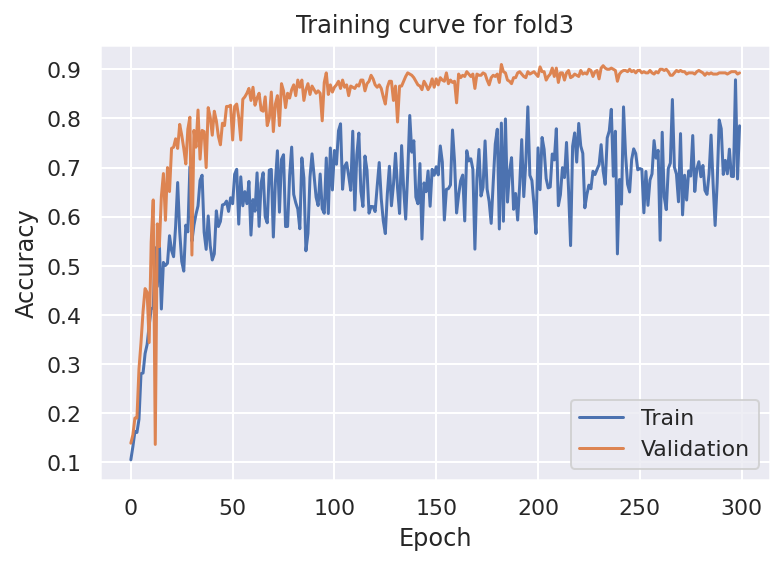

Epoch=0, Train loss=2.29274, Valid loss=2.30675, Train Accuracy=0.12289, Validation Accuracy=0.12225
Epoch=10, Train loss=1.95777, Valid loss=1.70057, Train Accuracy=0.40585, Validation Accuracy=0.41076
Epoch=20, Train loss=1.95826, Valid loss=1.28854, Train Accuracy=0.46508, Validation Accuracy=0.69193
Epoch=30, Train loss=1.52203, Valid loss=1.01128, Train Accuracy=0.67560, Validation Accuracy=0.72861
Epoch=40, Train loss=1.75392, Valid loss=1.15684, Train Accuracy=0.58591, Validation Accuracy=0.72127
Epoch=50, Train loss=1.62685, Valid loss=1.13886, Train Accuracy=0.65045, Validation Accuracy=0.76039
Epoch=60, Train loss=1.66891, Valid loss=1.04689, Train Accuracy=0.63809, Validation Accuracy=0.81663
Epoch=70, Train loss=1.83246, Valid loss=1.36696, Train Accuracy=0.55748, Validation Accuracy=0.76773
Epoch=80, Train loss=1.73155, Valid loss=1.25792, Train Accuracy=0.60135, Validation Accuracy=0.78484
Epoch=90, Train loss=1.74784, Valid loss=1.05137, Train Accuracy=0.59148, Validatio

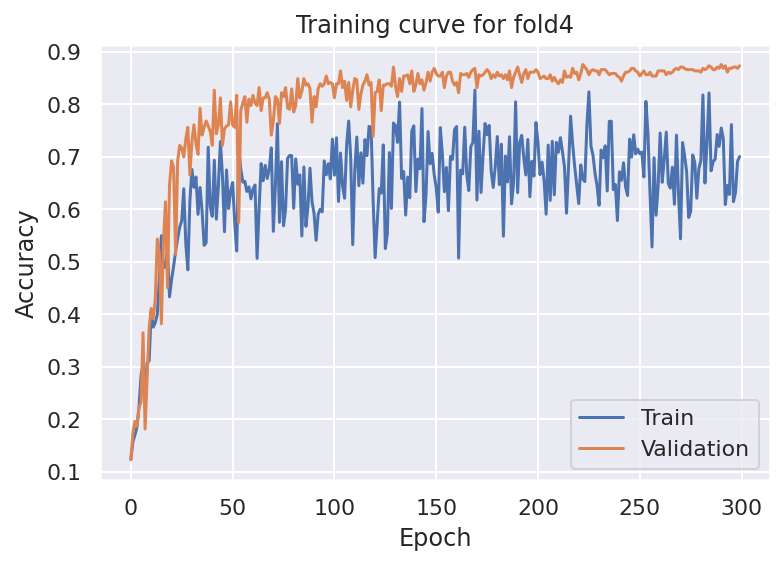

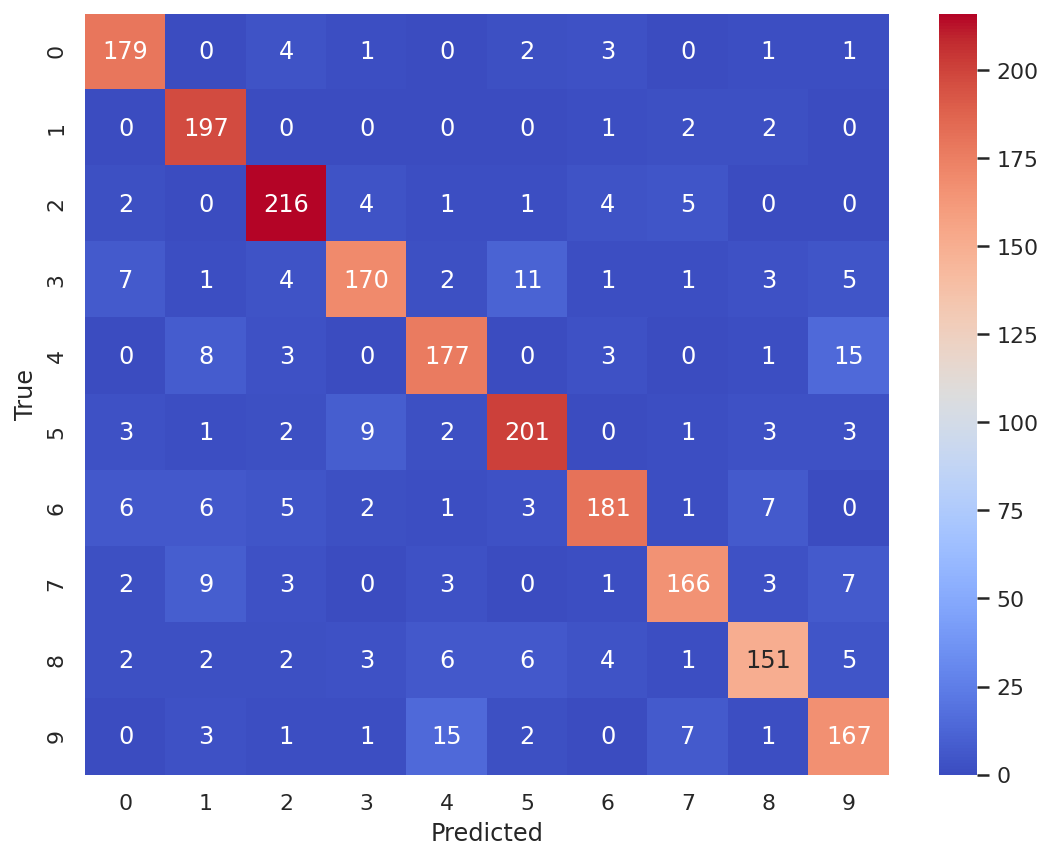

              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91       191
         1.0       0.87      0.98      0.92       202
         2.0       0.90      0.93      0.91       233
         3.0       0.89      0.83      0.86       205
         4.0       0.86      0.86      0.86       207
         5.0       0.89      0.89      0.89       225
         6.0       0.91      0.85      0.88       212
         7.0       0.90      0.86      0.88       194
         8.0       0.88      0.83      0.85       182
         9.0       0.82      0.85      0.84       197

    accuracy                           0.88      2048
   macro avg       0.88      0.88      0.88      2048
weighted avg       0.88      0.88      0.88      2048

CV Accuracy Score=0.88134765625
model=xresnet18, optimizer=radam, epochs=300, lr=0.003, wd=0.0005
CPU times: user 15min 11s, sys: 3min 21s, total: 18min 33s
Wall time: 20min 20s


In [143]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "xresnet18"
optim_name = "radam"
epochs = 300
lr = 3e-3
wd = 5e-4
oof, targs = run(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

### 2.1

Epoch=0, Train loss=2.30076, Valid loss=2.30234, Train Accuracy=0.09935, Validation Accuracy=0.11736
Epoch=10, Train loss=2.07526, Valid loss=1.84267, Train Accuracy=0.35612, Validation Accuracy=0.35452
Epoch=20, Train loss=1.81170, Valid loss=1.20688, Train Accuracy=0.54470, Validation Accuracy=0.71638
Epoch=30, Train loss=1.73836, Valid loss=1.03295, Train Accuracy=0.60782, Validation Accuracy=0.73594
Epoch=40, Train loss=1.50221, Valid loss=0.91757, Train Accuracy=0.70393, Validation Accuracy=0.81418
Epoch=50, Train loss=1.60328, Valid loss=0.88679, Train Accuracy=0.65655, Validation Accuracy=0.84841
Epoch=60, Train loss=1.43831, Valid loss=0.74254, Train Accuracy=0.72814, Validation Accuracy=0.86797
Epoch=70, Train loss=1.39463, Valid loss=0.72903, Train Accuracy=0.74854, Validation Accuracy=0.86553
Epoch=80, Train loss=1.57751, Valid loss=0.96368, Train Accuracy=0.67622, Validation Accuracy=0.78484
Epoch=90, Train loss=1.54977, Valid loss=0.83655, Train Accuracy=0.67294, Validatio

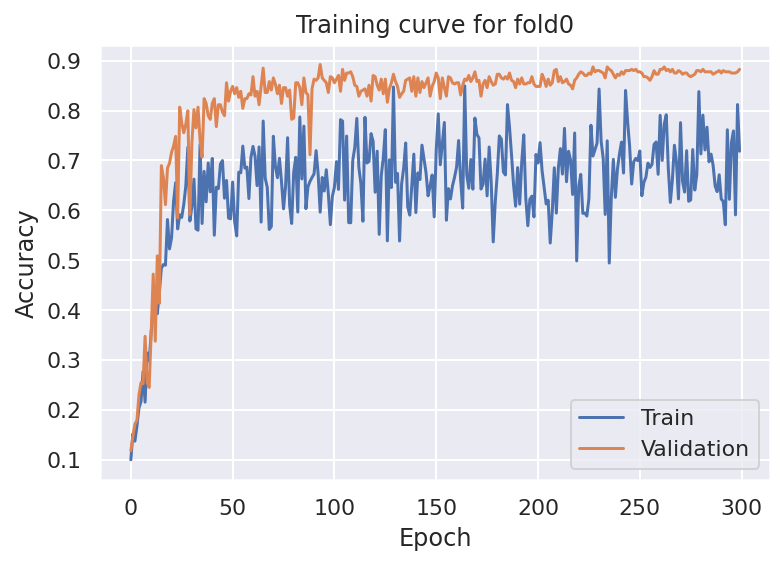

Epoch=0, Train loss=2.29966, Valid loss=2.30089, Train Accuracy=0.11040, Validation Accuracy=0.09512
Epoch=10, Train loss=2.11328, Valid loss=1.78051, Train Accuracy=0.31257, Validation Accuracy=0.42927
Epoch=20, Train loss=2.01957, Valid loss=1.20742, Train Accuracy=0.41699, Validation Accuracy=0.67561
Epoch=30, Train loss=1.65732, Valid loss=1.00501, Train Accuracy=0.62681, Validation Accuracy=0.77073
Epoch=40, Train loss=1.65323, Valid loss=0.81354, Train Accuracy=0.63976, Validation Accuracy=0.84146
Epoch=50, Train loss=1.51581, Valid loss=0.92749, Train Accuracy=0.69853, Validation Accuracy=0.83415
Epoch=60, Train loss=1.24794, Valid loss=0.69664, Train Accuracy=0.78960, Validation Accuracy=0.87073
Epoch=70, Train loss=1.54907, Valid loss=0.78084, Train Accuracy=0.68653, Validation Accuracy=0.87561
Epoch=80, Train loss=1.62674, Valid loss=0.87294, Train Accuracy=0.64031, Validation Accuracy=0.85610
Epoch=90, Train loss=1.45281, Valid loss=0.81187, Train Accuracy=0.71143, Validatio

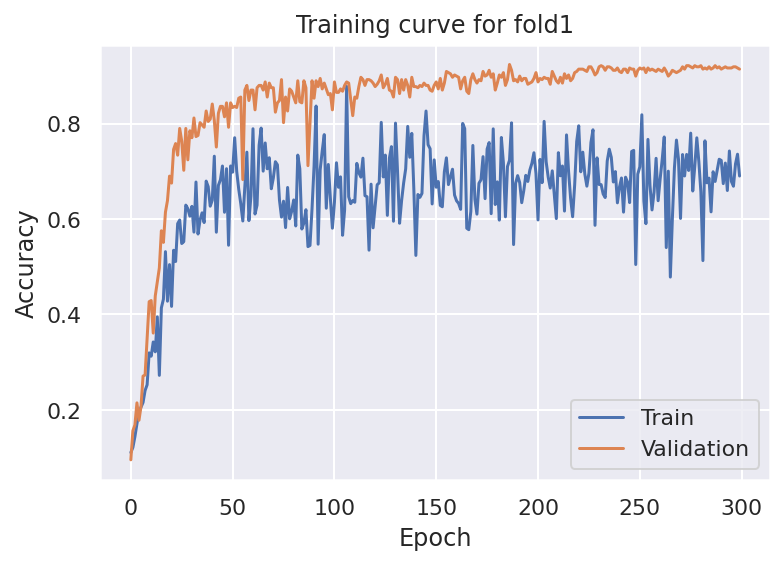

Epoch=0, Train loss=2.30134, Valid loss=2.30435, Train Accuracy=0.10594, Validation Accuracy=0.07317
Epoch=10, Train loss=2.07524, Valid loss=1.76582, Train Accuracy=0.35320, Validation Accuracy=0.44634
Epoch=20, Train loss=1.58541, Valid loss=1.04198, Train Accuracy=0.63733, Validation Accuracy=0.70244
Epoch=30, Train loss=1.94636, Valid loss=1.31251, Train Accuracy=0.50685, Validation Accuracy=0.65610
Epoch=40, Train loss=1.08235, Valid loss=0.67760, Train Accuracy=0.84069, Validation Accuracy=0.79512
Epoch=50, Train loss=1.71125, Valid loss=1.15511, Train Accuracy=0.59835, Validation Accuracy=0.81707
Epoch=60, Train loss=1.47706, Valid loss=0.80346, Train Accuracy=0.70827, Validation Accuracy=0.82439
Epoch=70, Train loss=1.65452, Valid loss=0.89663, Train Accuracy=0.65000, Validation Accuracy=0.82683
Epoch=80, Train loss=1.40775, Valid loss=0.74082, Train Accuracy=0.73010, Validation Accuracy=0.85854
Epoch=90, Train loss=1.56417, Valid loss=0.95418, Train Accuracy=0.68005, Validatio

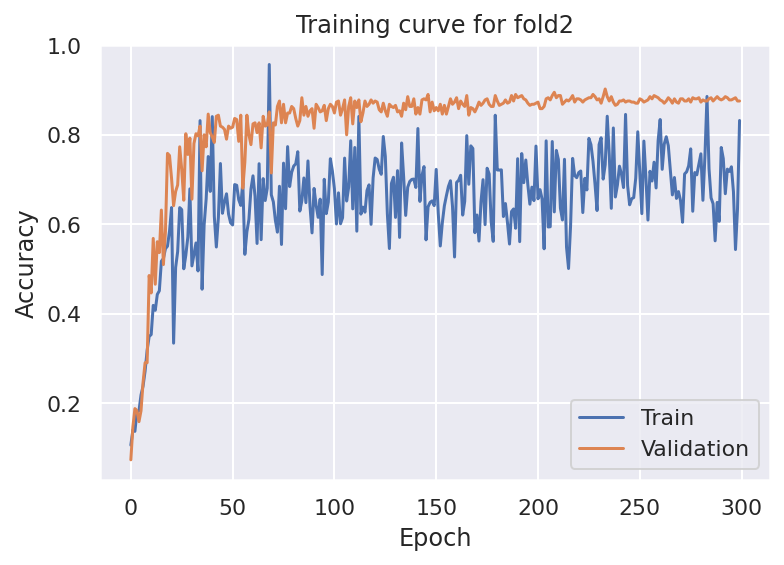

Epoch=0, Train loss=2.29816, Valid loss=2.30367, Train Accuracy=0.10745, Validation Accuracy=0.10000
Epoch=10, Train loss=2.17684, Valid loss=1.69349, Train Accuracy=0.29388, Validation Accuracy=0.42195
Epoch=20, Train loss=1.85913, Valid loss=1.33453, Train Accuracy=0.50817, Validation Accuracy=0.69756
Epoch=30, Train loss=1.64252, Valid loss=0.87581, Train Accuracy=0.63202, Validation Accuracy=0.81220
Epoch=40, Train loss=1.53075, Valid loss=0.87463, Train Accuracy=0.68522, Validation Accuracy=0.84878
Epoch=50, Train loss=1.58395, Valid loss=0.74812, Train Accuracy=0.66358, Validation Accuracy=0.86585
Epoch=60, Train loss=1.48405, Valid loss=0.81297, Train Accuracy=0.70265, Validation Accuracy=0.85610
Epoch=70, Train loss=1.43361, Valid loss=0.66330, Train Accuracy=0.73089, Validation Accuracy=0.89512
Epoch=80, Train loss=1.46029, Valid loss=0.66259, Train Accuracy=0.72499, Validation Accuracy=0.90244
Epoch=90, Train loss=1.75041, Valid loss=0.88227, Train Accuracy=0.59045, Validatio

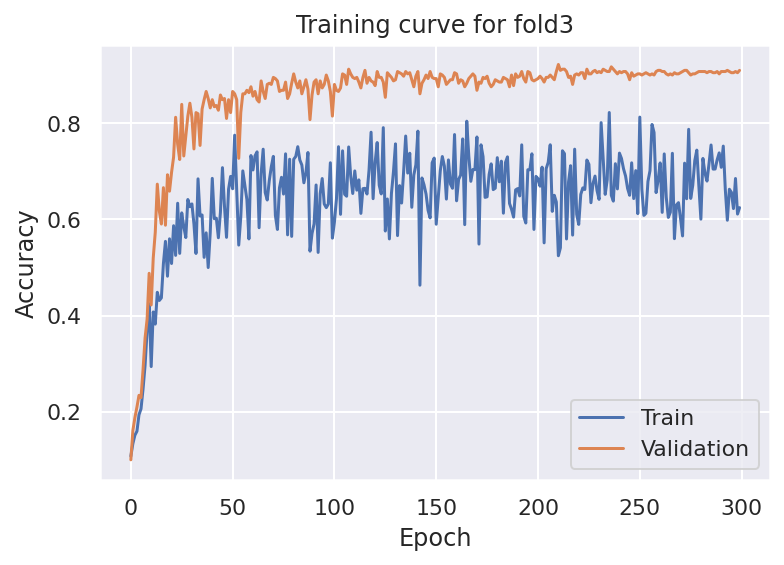

Epoch=0, Train loss=2.29951, Valid loss=2.30338, Train Accuracy=0.10307, Validation Accuracy=0.12225
Epoch=10, Train loss=2.11758, Valid loss=1.96216, Train Accuracy=0.31204, Validation Accuracy=0.31296
Epoch=20, Train loss=1.89829, Valid loss=1.47207, Train Accuracy=0.50408, Validation Accuracy=0.60880
Epoch=30, Train loss=1.86683, Valid loss=1.03429, Train Accuracy=0.52957, Validation Accuracy=0.74817
Epoch=40, Train loss=1.35234, Valid loss=0.88268, Train Accuracy=0.75202, Validation Accuracy=0.79707
Epoch=50, Train loss=1.51401, Valid loss=0.95339, Train Accuracy=0.68874, Validation Accuracy=0.80685
Epoch=60, Train loss=1.81811, Valid loss=1.06257, Train Accuracy=0.55135, Validation Accuracy=0.84841
Epoch=70, Train loss=1.27582, Valid loss=0.82479, Train Accuracy=0.78589, Validation Accuracy=0.83374
Epoch=80, Train loss=1.74222, Valid loss=0.96431, Train Accuracy=0.61081, Validation Accuracy=0.81663
Epoch=90, Train loss=1.68126, Valid loss=0.99217, Train Accuracy=0.61887, Validatio

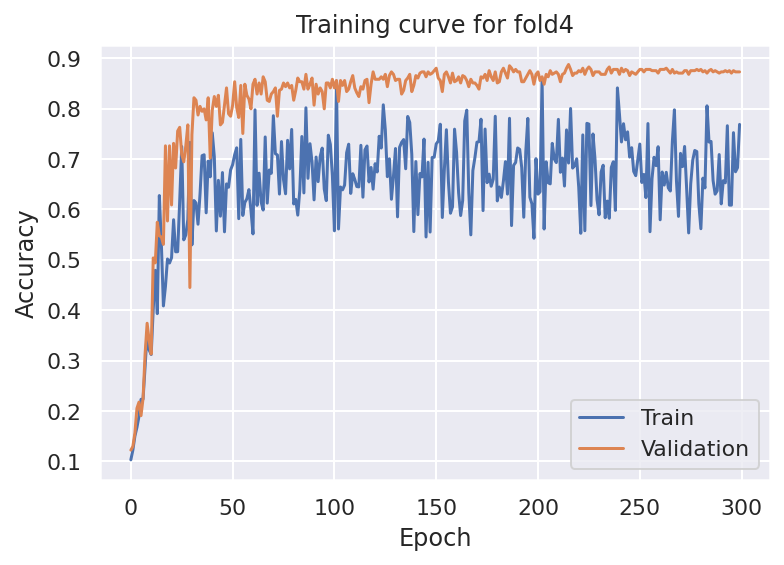

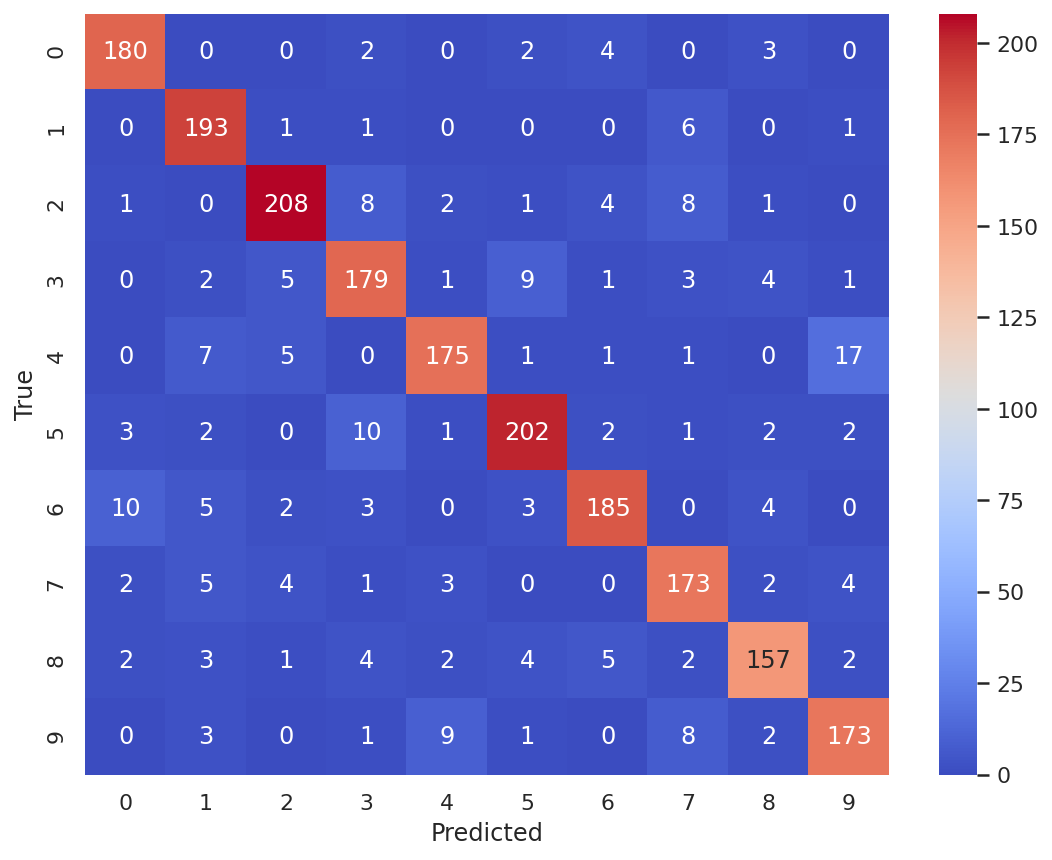

              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93       191
         1.0       0.88      0.96      0.91       202
         2.0       0.92      0.89      0.91       233
         3.0       0.86      0.87      0.86       205
         4.0       0.91      0.85      0.88       207
         5.0       0.91      0.90      0.90       225
         6.0       0.92      0.87      0.89       212
         7.0       0.86      0.89      0.87       194
         8.0       0.90      0.86      0.88       182
         9.0       0.86      0.88      0.87       197

    accuracy                           0.89      2048
   macro avg       0.89      0.89      0.89      2048
weighted avg       0.89      0.89      0.89      2048

CV Accuracy Score=0.89111328125
model=xresnet34, optimizer=radam, epochs=300, lr=0.003, wd=0.0005
CPU times: user 23min 8s, sys: 3min 21s, total: 26min 30s
Wall time: 28min 18s


In [144]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "xresnet34"
optim_name = "radam"
epochs = 300
lr = 3e-3
wd = 5e-4
oof, targs = run(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

### 2.2

Epoch=0, Train loss=2.29219, Valid loss=2.28007, Train Accuracy=0.12493, Validation Accuracy=0.13692
Epoch=10, Train loss=2.07308, Valid loss=1.55833, Train Accuracy=0.36323, Validation Accuracy=0.53545
Epoch=20, Train loss=1.84139, Valid loss=1.21717, Train Accuracy=0.53372, Validation Accuracy=0.74817
Epoch=30, Train loss=1.45614, Valid loss=0.92090, Train Accuracy=0.70368, Validation Accuracy=0.76039
Epoch=40, Train loss=1.62524, Valid loss=0.84948, Train Accuracy=0.64308, Validation Accuracy=0.79462
Epoch=50, Train loss=1.81363, Valid loss=1.17142, Train Accuracy=0.56269, Validation Accuracy=0.76773
Epoch=60, Train loss=1.34272, Valid loss=0.73078, Train Accuracy=0.75184, Validation Accuracy=0.81174
Epoch=70, Train loss=1.58384, Valid loss=1.11746, Train Accuracy=0.67238, Validation Accuracy=0.81418
Epoch=80, Train loss=1.79880, Valid loss=1.08573, Train Accuracy=0.56575, Validation Accuracy=0.83619
Epoch=90, Train loss=1.73947, Valid loss=1.04761, Train Accuracy=0.59903, Validatio

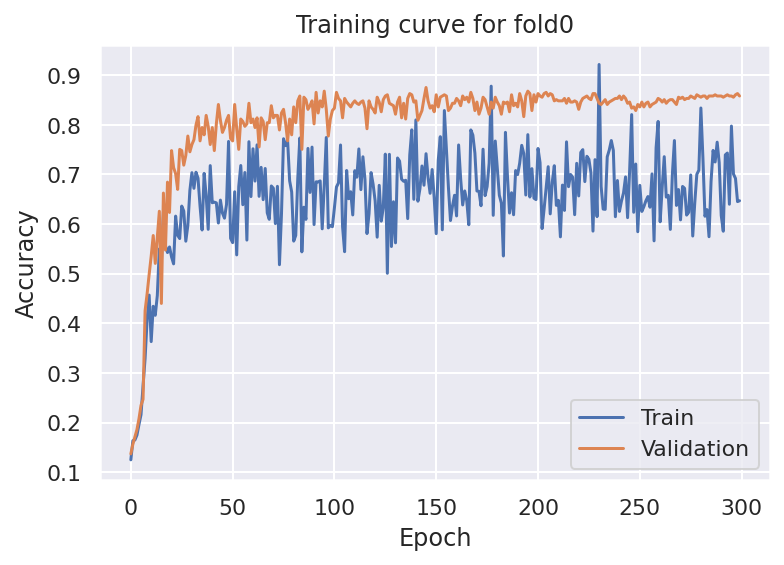

Epoch=0, Train loss=2.30405, Valid loss=2.28438, Train Accuracy=0.11189, Validation Accuracy=0.13415
Epoch=10, Train loss=1.96299, Valid loss=1.78044, Train Accuracy=0.41671, Validation Accuracy=0.41707
Epoch=20, Train loss=1.65982, Valid loss=1.07825, Train Accuracy=0.59120, Validation Accuracy=0.70976
Epoch=30, Train loss=1.66740, Valid loss=1.09764, Train Accuracy=0.62318, Validation Accuracy=0.74878
Epoch=40, Train loss=1.62524, Valid loss=1.13053, Train Accuracy=0.63926, Validation Accuracy=0.74878
Epoch=50, Train loss=1.42341, Valid loss=0.81958, Train Accuracy=0.73684, Validation Accuracy=0.78049
Epoch=60, Train loss=1.83482, Valid loss=1.05900, Train Accuracy=0.54363, Validation Accuracy=0.85122
Epoch=70, Train loss=1.67908, Valid loss=0.92266, Train Accuracy=0.62560, Validation Accuracy=0.85366
Epoch=80, Train loss=1.54564, Valid loss=0.99521, Train Accuracy=0.67374, Validation Accuracy=0.84146
Epoch=90, Train loss=1.46765, Valid loss=0.83642, Train Accuracy=0.71534, Validatio

In [ ]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "xresnet50"
optim_name = "radam"
epochs = 300
lr = 3e-3
wd = 5e-4
oof, targs = run(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")